In [1]:
import gym
import numpy as np
from model import *

""" Set all parameters """
discount = 0.99
lr_term = 0.25
lr_intra = 0.25
lr_critic = 0.5
epsilon = 0.01
temperature = 0.1
noptions = 4
nsteps = 1000
nruns = 1
nepisodes = 8000
change_step = 2000

verbose = True
save = True
experiment = "experiment5"

[2017-11-16 19:39:14,449] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace any calls to `register(timestep_limit=200)` with `register(tags={'wrapper_config.TimeLimit.max_episode_steps': 200)}`, . This change was made 12/28/2016 and is included in gym version 0.7.0. If you are getting many of these warnings, you may need to update universe past version 0.21.1


In [2]:
from scipy.special import logsumexp, expit        

""" Compute model of the environment (action expected rewards and transitions) """
def compute_dynamics(env):
    nfeatures, nactions = env.observation_space.n, env.action_space.n

    R_env = np.zeros((nfeatures, nactions))
    r, c = env.tocell[env.goal]
    for r_diff, c_diff in env.directions:
        r_new, c_new = r + r_diff, c + c_diff
        if not env.occupancy[r_new, c_new]:
            for a in xrange(nactions):
                r_diff2, c_diff2 = env.directions[a]
                r_new2, c_new2 = r_new + r_diff2, c_new + c_diff2
                if r_new2 == r and  c_new2 == c:
                    R_env[env.tostate[(r_new, c_new)], a] = 2./3
                else:
                    R_env[env.tostate[(r_new, c_new)], a] = 1./9

    P_env = np.zeros((nfeatures, nactions, nfeatures))
    for r in xrange(13):
        for c in xrange(13):
            if env.occupancy[r, c] == 0:
                for move in xrange(nactions):
                    r_diff, c_diff = env.directions[move]
                    r_new, c_new = r + r_diff, c + c_diff
                    for a in xrange(nactions):
                        if a == move:
                            if env.occupancy[r_new, c_new]:
                                P_env[env.tostate[(r, c)], a, env.tostate[(r, c)]] += 2./3
                            else:
                                P_env[env.tostate[(r, c)], a, env.tostate[(r_new, c_new)]] += 2./3
                        else:
                            if env.occupancy[r_new, c_new]:
                                P_env[env.tostate[(r, c)], a, env.tostate[(r, c)]] += 1./9
                            else:
                                P_env[env.tostate[(r, c)], a, env.tostate[(r_new, c_new)]] += 1./9      
                                
    return R_env, P_env

""" Compute model of our options (expected rewards and transitions) by dynamic programming """
def model_learning_dp(option_policies, option_terminations, env, threshold = 1e-12):
    R_env, P_env = compute_dynamics(env)
    
    nfeatures, nactions = env.observation_space.n, env.action_space.n
    R = np.zeros((nfeatures, noptions))
    P = np.zeros((nfeatures, noptions, nfeatures))

    def iterate():
        for j in xrange(noptions):
            # Compute pi 
            weights = option_policies[j].weights / temperature
            pi = np.exp(weights - logsumexp(weights, axis=1, keepdims=True))
            # Compute beta
            beta = expit(option_terminations[j].weights)
            # Update R
            R[:, j] = (pi * (R_env + discount * P_env.dot((1 - beta) * R[:, j]))).sum(axis=1)
            # Update P
            P[:, j, :] = (pi[:, :, np.newaxis] * discount * (P_env * beta + (P_env * (1 - beta)).dot(P[:, j, :]))).sum(axis=1)

    R_old, P_old = np.copy(R), np.copy(P)
    iterate()
    while np.sum((R - R_old) ** 2) > threshold or np.sum((P - P_old) ** 2) > threshold:
        R_old[:], P_old[:] = R, P
        iterate()
        
    return R, P

In [3]:
import pickle

""" First pass: compute true model of options by dynamic programming and record history """
rng = np.random.RandomState(1234)
env = gym.make('Fourrooms-v0')
nfeatures, nactions = env.observation_space.n, env.action_space.n

goals = [62, 0, 40, 95]

# Record number of steps per episode and average duration of options
history = np.zeros((nruns, nepisodes, 2))

# Record true model of options before every goal change
R = np.zeros((nruns, len(goals), nfeatures, noptions))
P = np.zeros((nruns, len(goals), nfeatures, noptions, nfeatures))

for run in range(nruns):
    features = Tabular(env.observation_space.n)
    nfeatures, nactions = len(features), env.action_space.n

    # The intra-option policies are linear-softmax functions
    option_policies = [SoftmaxPolicy(rng, nfeatures, nactions, temperature)
                       for _ in range(noptions)]

    # The termination function are linear-sigmoid functions
    option_terminations = [SigmoidTermination(rng, nfeatures) 
                           for _ in range(noptions)]

    # E-greedy policy over options
    #policy_over_options = EgreedyPolicy(rng, nfeatures, noptions, epsilon)
    policy_over_options = SoftmaxPolicy(rng, nfeatures, noptions, 0.001)

    # Different choices are possible for the critic. Here we learn an
    # option-value function and use the estimator for the values upon arrival
    critic = IntraOptionQLearning(discount, lr_critic, 
                                  option_terminations, policy_over_options.weights)

    # Learn Qomega separately
    action_weights = np.zeros((nfeatures, noptions, nactions))
    action_critic = IntraOptionActionQLearning(discount, lr_critic, 
                                               option_terminations, 
                                               action_weights, critic)

    # Improvement of the termination functions based on gradients
    termination_improvement = TerminationGradient(option_terminations, 
                                                  critic, lr_term)

    # Intra-option gradient improvement with critic estimator
    intraoption_improvement = IntraOptionGradient(option_policies, 
                                                  lr_intra)

    goal_idx = 0
    for episode in xrange(nepisodes):     
        if episode == change_step * (goal_idx + 1):
            # Record true model of current options
            R[run, goal_idx], P[run, goal_idx] = model_learning_dp(option_policies, option_terminations, env)
            
            # Save current option policies and termination functions
            pickle.dump(option_policies, 
                        open("save/policies_{}.p".format(goal_idx), "wb"))
            pickle.dump(option_terminations, 
                        open("save/terminations_{}.p".format(goal_idx), "wb"))    
            pickle.dump(policy_over_options, 
                        open("save/mainpolicy_{}.p".format(goal_idx), "wb"))
            
            # Change goal
            goal_idx += 1  
            env.goal = goals[goal_idx]
        
        phi = features(env.reset())
        option = policy_over_options.sample(phi)
        action = option_policies[option].sample(phi)
        critic.start(phi, option)
        action_critic.start(phi, option, action)

        cumreward = 0.
        duration = 1
        option_switches = 0
        avgduration = 0.

        for step in range(nsteps):
            observation, reward, done, _ = env.step(action)
            phi = features(observation)

            # Termination might occur upon entering the new state
            if option_terminations[option].sample(phi):
                option = policy_over_options.sample(phi)
                option_switches += 1
                avgduration += (1. / option_switches) * \
                    (duration - avgduration)
                duration = 1

            action = option_policies[option].sample(phi)

            # Critic update
            update_target = critic.update(phi, option, reward, done)
            action_critic.update(phi, option, action, reward, done)

            # Intra-option policy update
            critic_feedback = action_critic.value(phi, option, action)
            critic_feedback -= critic.value(phi, option)
            intraoption_improvement.update(phi, option, action, 
                                           critic_feedback)
            # Termination update
            termination_improvement.update(phi, option)

            cumreward += reward
            duration += 1
            if done:
                break
                
        history[run, episode, 0] = step
        history[run, episode, 1] = avgduration

        if verbose:
            print('Run {} episode {} steps {} cumreward {} avg. duration \
                {} switches {}'.format(run, episode, step, cumreward, 
                                       avgduration, option_switches))
            
    # Record true model of current options
    R[run, goal_idx], P[run, goal_idx] = model_learning_dp(option_policies, option_terminations, env)
    
    # Save current option policies and termination functions
    pickle.dump(option_policies, 
                open("save/policies_{}.p".format(goal_idx), "wb"))
    pickle.dump(option_terminations, 
                open("save/terminations_{}.p".format(goal_idx), "wb"))    
    pickle.dump(policy_over_options, 
                open("save/mainpolicy_{}.p".format(goal_idx), "wb"))

[2017-11-16 19:39:15,190] Making new env: Fourrooms-v0


Run 0 episode 0 steps 101 cumreward 1.0 avg. duration                 3.12765957447 switches 47
Run 0 episode 1 steps 145 cumreward 1.0 avg. duration                 2.89473684211 switches 76
Run 0 episode 2 steps 887 cumreward 1.0 avg. duration                 3.04861111111 switches 432
Run 0 episode 3 steps 624 cumreward 1.0 avg. duration                 2.88787878788 switches 330
Run 0 episode 4 steps 32 cumreward 1.0 avg. duration                 2.72222222222 switches 18
Run 0 episode 5 steps 185 cumreward 1.0 avg. duration                 2.85 switches 100
Run 0 episode 6 steps 857 cumreward 1.0 avg. duration                 2.97685185185 switches 432
Run 0 episode 7 steps 7 cumreward 1.0 avg. duration                 2.4 switches 5
Run 0 episode 8 steps 201 cumreward 1.0 avg. duration                 3.42168674699 switches 83
Run 0 episode 9 steps 149 cumreward 1.0 avg. duration                 2.87341772152 switches 79
Run 0 episode 10 steps 66 cumreward 1.0 avg. duration      

Run 0 episode 93 steps 144 cumreward 1.0 avg. duration                 2.66279069767 switches 86
Run 0 episode 94 steps 6 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 95 steps 139 cumreward 1.0 avg. duration                 2.95774647887 switches 71
Run 0 episode 96 steps 15 cumreward 1.0 avg. duration                 2.66666666667 switches 9
Run 0 episode 97 steps 23 cumreward 1.0 avg. duration                 2.91666666667 switches 12
Run 0 episode 98 steps 152 cumreward 1.0 avg. duration                 3.02666666667 switches 75
Run 0 episode 99 steps 10 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 100 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 101 steps 1 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 102 steps 6 cumreward 1.0 avg. duration                 4.0 switches 2
Run 0 episode 103 steps 13 cumreward 1.0 avg. duration                 2.7142857142

Run 0 episode 191 steps 29 cumreward 1.0 avg. duration                 2.6875 switches 16
Run 0 episode 192 steps 8 cumreward 1.0 avg. duration                 3.66666666667 switches 3
Run 0 episode 193 steps 7 cumreward 1.0 avg. duration                 3.0 switches 3
Run 0 episode 194 steps 34 cumreward 1.0 avg. duration                 2.88888888889 switches 18
Run 0 episode 195 steps 2 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 196 steps 16 cumreward 1.0 avg. duration                 2.77777777778 switches 9
Run 0 episode 197 steps 21 cumreward 1.0 avg. duration                 2.90909090909 switches 11
Run 0 episode 198 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 199 steps 35 cumreward 1.0 avg. duration                 2.78947368421 switches 19
Run 0 episode 200 steps 13 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 201 steps 18 cumreward 1.0 avg. duration                 2.4545

Run 0 episode 305 steps 11 cumreward 1.0 avg. duration                 2.25 switches 8
Run 0 episode 306 steps 17 cumreward 1.0 avg. duration                 2.45454545455 switches 11
Run 0 episode 307 steps 11 cumreward 1.0 avg. duration                 3.5 switches 4
Run 0 episode 308 steps 19 cumreward 1.0 avg. duration                 2.9 switches 10
Run 0 episode 309 steps 2 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 310 steps 18 cumreward 1.0 avg. duration                 3.125 switches 8
Run 0 episode 311 steps 3 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 312 steps 9 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 313 steps 14 cumreward 1.0 avg. duration                 3.4 switches 5
Run 0 episode 314 steps 10 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 315 steps 11 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 316 steps 13 cumre

Run 0 episode 424 steps 15 cumreward 1.0 avg. duration                 3.16666666667 switches 6
Run 0 episode 425 steps 8 cumreward 1.0 avg. duration                 2.6 switches 5
Run 0 episode 426 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 427 steps 5 cumreward 1.0 avg. duration                 3.0 switches 2
Run 0 episode 428 steps 5 cumreward 1.0 avg. duration                 3.0 switches 2
Run 0 episode 429 steps 13 cumreward 1.0 avg. duration                 2.625 switches 8
Run 0 episode 430 steps 22 cumreward 1.0 avg. duration                 2.83333333333 switches 12
Run 0 episode 431 steps 6 cumreward 1.0 avg. duration                 3.0 switches 3
Run 0 episode 432 steps 15 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 433 steps 7 cumreward 1.0 avg. duration                 3.5 switches 2
Run 0 episode 434 steps 5 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 435

Run 0 episode 517 steps 15 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 518 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 519 steps 12 cumreward 1.0 avg. duration                 3.4 switches 5
Run 0 episode 520 steps 7 cumreward 1.0 avg. duration                 2.75 switches 4
Run 0 episode 521 steps 11 cumreward 1.0 avg. duration                 2.22222222222 switches 9
Run 0 episode 522 steps 10 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 523 steps 18 cumreward 1.0 avg. duration                 2.7 switches 10
Run 0 episode 524 steps 12 cumreward 1.0 avg. duration                 2.5 switches 8
Run 0 episode 525 steps 15 cumreward 1.0 avg. duration                 2.875 switches 8
Run 0 episode 526 steps 10 cumreward 1.0 avg. duration                 4.33333333333 switches 3
Run 0 episode 527 steps 11 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 episode 528 ste

Run 0 episode 620 steps 17 cumreward 1.0 avg. duration                 2.77777777778 switches 9
Run 0 episode 621 steps 16 cumreward 1.0 avg. duration                 2.44444444444 switches 9
Run 0 episode 622 steps 6 cumreward 1.0 avg. duration                 3.0 switches 2
Run 0 episode 623 steps 6 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 624 steps 11 cumreward 1.0 avg. duration                 2.25 switches 8
Run 0 episode 625 steps 13 cumreward 1.0 avg. duration                 4.0 switches 4
Run 0 episode 626 steps 20 cumreward 1.0 avg. duration                 3.0 switches 10
Run 0 episode 627 steps 9 cumreward 1.0 avg. duration                 2.8 switches 5
Run 0 episode 628 steps 11 cumreward 1.0 avg. duration                 4.66666666667 switches 3
Run 0 episode 629 steps 12 cumreward 1.0 avg. duration                 2.2 switches 10
Run 0 episode 630 steps 6 cumreward 1.0 avg. duration                 3.0 switches 1
Run 0 episode 631 steps 

Run 0 episode 727 steps 21 cumreward 1.0 avg. duration                 2.42857142857 switches 14
Run 0 episode 728 steps 9 cumreward 1.0 avg. duration                 3.25 switches 4
Run 0 episode 729 steps 10 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 730 steps 15 cumreward 1.0 avg. duration                 2.625 switches 8
Run 0 episode 731 steps 9 cumreward 1.0 avg. duration                 2.6 switches 5
Run 0 episode 732 steps 14 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 733 steps 10 cumreward 1.0 avg. duration                 2.25 switches 8
Run 0 episode 734 steps 11 cumreward 1.0 avg. duration                 3.0 switches 4
Run 0 episode 735 steps 23 cumreward 1.0 avg. duration                 3.0 switches 11
Run 0 episode 736 steps 7 cumreward 1.0 avg. duration                 3.0 switches 3
Run 0 episode 737 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 738 steps 16 cumre

Run 0 episode 821 steps 13 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 822 steps 6 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 823 steps 5 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 824 steps 18 cumreward 1.0 avg. duration                 3.0 switches 9
Run 0 episode 825 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 826 steps 4 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 827 steps 8 cumreward 1.0 avg. duration                 2.6 switches 5
Run 0 episode 828 steps 4 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 829 steps 6 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 830 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 831 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 832 steps 12 cumreward 1.0 

Run 0 episode 913 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 914 steps 12 cumreward 1.0 avg. duration                 4.0 switches 4
Run 0 episode 915 steps 11 cumreward 1.0 avg. duration                 3.2 switches 5
Run 0 episode 916 steps 9 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 917 steps 10 cumreward 1.0 avg. duration                 2.25 switches 8
Run 0 episode 918 steps 18 cumreward 1.0 avg. duration                 2.28571428571 switches 14
Run 0 episode 919 steps 3 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 920 steps 5 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 921 steps 8 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 922 steps 3 cumreward 1.0 avg. duration                 4.0 switches 1
Run 0 episode 923 steps 5 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 924 s

Run 0 episode 1004 steps 7 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 1005 steps 7 cumreward 1.0 avg. duration                 1.83333333333 switches 6
Run 0 episode 1006 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 1007 steps 10 cumreward 1.0 avg. duration                 3.5 switches 4
Run 0 episode 1008 steps 9 cumreward 1.0 avg. duration                 2.6 switches 5
Run 0 episode 1009 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 1010 steps 9 cumreward 1.0 avg. duration                 2.0 switches 9
Run 0 episode 1011 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 1012 steps 20 cumreward 1.0 avg. duration                 2.9 switches 10
Run 0 episode 1013 steps 7 cumreward 1.0 avg. duration                 2.75 switches 4
Run 0 episode 1014 steps 17 cumreward 1.0 avg. duration                 3.83333333333 switches 6
Run 0 episode 1015 steps 7 cu

Run 0 episode 1102 steps 6 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 1103 steps 12 cumreward 1.0 avg. duration                 3.0 switches 6
Run 0 episode 1104 steps 8 cumreward 1.0 avg. duration                 2.16666666667 switches 6
Run 0 episode 1105 steps 3 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 1106 steps 13 cumreward 1.0 avg. duration                 2.22222222222 switches 9
Run 0 episode 1107 steps 8 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 1108 steps 17 cumreward 1.0 avg. duration                 3.125 switches 8
Run 0 episode 1109 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 1110 steps 10 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 1111 steps 5 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 1112 steps 7 cumreward 1.0 avg. duration                 2.4

Run 0 episode 1203 steps 8 cumreward 1.0 avg. duration                 2.16666666667 switches 6
Run 0 episode 1204 steps 8 cumreward 1.0 avg. duration                 2.75 switches 4
Run 0 episode 1205 steps 4 cumreward 1.0 avg. duration                 3.0 switches 2
Run 0 episode 1206 steps 14 cumreward 1.0 avg. duration                 2.55555555556 switches 9
Run 0 episode 1207 steps 8 cumreward 1.0 avg. duration                 2.6 switches 5
Run 0 episode 1208 steps 12 cumreward 1.0 avg. duration                 4.0 switches 4
Run 0 episode 1209 steps 6 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 1210 steps 4 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 1211 steps 3 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 1212 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 1213 steps 2 cumreward 1.0 avg. duration                 3.0 switches 1
Run 0 episode 1214 steps 4 cumr

Run 0 episode 1304 steps 7 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 1305 steps 12 cumreward 1.0 avg. duration                 2.83333333333 switches 6
Run 0 episode 1306 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 1307 steps 11 cumreward 1.0 avg. duration                 2.125 switches 8
Run 0 episode 1308 steps 11 cumreward 1.0 avg. duration                 2.83333333333 switches 6
Run 0 episode 1309 steps 8 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 1310 steps 13 cumreward 1.0 avg. duration                 3.0 switches 6
Run 0 episode 1311 steps 17 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 1312 steps 16 cumreward 1.0 avg. duration                 4.2 switches 5
Run 0 episode 1313 steps 3 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 1314 steps 5 cumreward 1.0 avg. duration                 3.0 switc

Run 0 episode 1395 steps 6 cumreward 1.0 avg. duration                 4.0 switches 2
Run 0 episode 1396 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 1397 steps 5 cumreward 1.0 avg. duration                 3.0 switches 2
Run 0 episode 1398 steps 8 cumreward 1.0 avg. duration                 3.33333333333 switches 3
Run 0 episode 1399 steps 15 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 1400 steps 12 cumreward 1.0 avg. duration                 2.71428571429 switches 7
Run 0 episode 1401 steps 2 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 1402 steps 2 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 1403 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 1404 steps 1 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 1405 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 1406 ste

Run 0 episode 1497 steps 14 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 1498 steps 2 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 1499 steps 12 cumreward 1.0 avg. duration                 2.2 switches 10
Run 0 episode 1500 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 1501 steps 1 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 1502 steps 8 cumreward 1.0 avg. duration                 2.0 switches 8
Run 0 episode 1503 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 1504 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 1505 steps 14 cumreward 1.0 avg. duration                 2.75 switches 8
Run 0 episode 1506 steps 15 cumreward 1.0 avg. duration                 3.14285714286 switches 7
Run 0 episode 1507 steps 15 cumreward 1.0 avg. duration                 3.5 switches 6
Run 0 episode 150

Run 0 episode 1592 steps 7 cumreward 1.0 avg. duration                 1.875 switches 8
Run 0 episode 1593 steps 6 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 1594 steps 14 cumreward 1.0 avg. duration                 2.83333333333 switches 6
Run 0 episode 1595 steps 10 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 episode 1596 steps 9 cumreward 1.0 avg. duration                 4.0 switches 3
Run 0 episode 1597 steps 9 cumreward 1.0 avg. duration                 3.66666666667 switches 3
Run 0 episode 1598 steps 13 cumreward 1.0 avg. duration                 2.44444444444 switches 9
Run 0 episode 1599 steps 11 cumreward 1.0 avg. duration                 2.22222222222 switches 9
Run 0 episode 1600 steps 3 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 1601 steps 15 cumreward 1.0 avg. duration                 2.75 switches 8
Run 0 episode 1602 steps 3 cumreward 1.0 avg. duration                 2

Run 0 episode 1704 steps 5 cumreward 1.0 avg. duration                 1.83333333333 switches 6
Run 0 episode 1705 steps 13 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 1706 steps 8 cumreward 1.0 avg. duration                 2.0 switches 8
Run 0 episode 1707 steps 9 cumreward 1.0 avg. duration                 2.125 switches 8
Run 0 episode 1708 steps 14 cumreward 1.0 avg. duration                 2.71428571429 switches 7
Run 0 episode 1709 steps 2 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 1710 steps 11 cumreward 1.0 avg. duration                 4.0 switches 3
Run 0 episode 1711 steps 12 cumreward 1.0 avg. duration                 3.33333333333 switches 3
Run 0 episode 1712 steps 15 cumreward 1.0 avg. duration                 2.75 switches 8
Run 0 episode 1713 steps 15 cumreward 1.0 avg. duration                 4.0 switches 5
Run 0 episode 1714 steps 5 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0

Run 0 episode 1821 steps 10 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 1822 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 1823 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 1824 steps 11 cumreward 1.0 avg. duration                 2.22222222222 switches 9
Run 0 episode 1825 steps 8 cumreward 1.0 avg. duration                 2.6 switches 5
Run 0 episode 1826 steps 2 cumreward 1.0 avg. duration                 3.0 switches 1
Run 0 episode 1827 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 1828 steps 12 cumreward 1.0 avg. duration                 4.33333333333 switches 3
Run 0 episode 1829 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 1830 steps 21 cumreward 1.0 avg. duration                 4.16666666667 switches 6
Run 0 episode 1831 steps 13 cumreward 1.0 avg. duration                 2.5 switches 8
Run 0 epi

Run 0 episode 1920 steps 11 cumreward 1.0 avg. duration                 3.2 switches 5
Run 0 episode 1921 steps 2 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 1922 steps 10 cumreward 1.0 avg. duration                 3.0 switches 5
Run 0 episode 1923 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 1924 steps 15 cumreward 1.0 avg. duration                 2.5 switches 10
Run 0 episode 1925 steps 3 cumreward 1.0 avg. duration                 4.0 switches 1
Run 0 episode 1926 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 1927 steps 18 cumreward 1.0 avg. duration                 2.63636363636 switches 11
Run 0 episode 1928 steps 6 cumreward 1.0 avg. duration                 3.0 switches 3
Run 0 episode 1929 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 1930 steps 1 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 1931 steps 13 cumreward 

Run 0 episode 2010 steps 999 cumreward 0.0 avg. duration                 2.87593984962 switches 532
Run 0 episode 2011 steps 999 cumreward 0.0 avg. duration                 2.83302752294 switches 545
Run 0 episode 2012 steps 999 cumreward 0.0 avg. duration                 2.75087719298 switches 570
Run 0 episode 2013 steps 999 cumreward 0.0 avg. duration                 2.80650994575 switches 553
Run 0 episode 2014 steps 999 cumreward 0.0 avg. duration                 2.83302752294 switches 545
Run 0 episode 2015 steps 999 cumreward 0.0 avg. duration                 2.72664359862 switches 578
Run 0 episode 2016 steps 999 cumreward 0.0 avg. duration                 2.87078651685 switches 534
Run 0 episode 2017 steps 999 cumreward 0.0 avg. duration                 2.87593984962 switches 532
Run 0 episode 2018 steps 999 cumreward 0.0 avg. duration                 2.85634328358 switches 536
Run 0 episode 2019 steps 999 cumreward 0.0 avg. duration                 2.7619047619 switches 567
R

Run 0 episode 2096 steps 69 cumreward 1.0 avg. duration                 2.78947368421 switches 38
Run 0 episode 2097 steps 75 cumreward 1.0 avg. duration                 2.875 switches 40
Run 0 episode 2098 steps 63 cumreward 1.0 avg. duration                 2.90909090909 switches 33
Run 0 episode 2099 steps 31 cumreward 1.0 avg. duration                 2.82352941176 switches 17
Run 0 episode 2100 steps 140 cumreward 1.0 avg. duration                 2.82666666667 switches 75
Run 0 episode 2101 steps 37 cumreward 1.0 avg. duration                 3.64285714286 switches 14
Run 0 episode 2102 steps 3 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 2103 steps 174 cumreward 1.0 avg. duration                 3.06024096386 switches 83
Run 0 episode 2104 steps 100 cumreward 1.0 avg. duration                 2.68965517241 switches 58
Run 0 episode 2105 steps 6 cumreward 1.0 avg. duration                 3.0 switches 3
Run 0 episode 2106 steps 94 cumreward 1.0 avg. du

Run 0 episode 2188 steps 45 cumreward 1.0 avg. duration                 2.55172413793 switches 29
Run 0 episode 2189 steps 51 cumreward 1.0 avg. duration                 3.21739130435 switches 23
Run 0 episode 2190 steps 21 cumreward 1.0 avg. duration                 2.90909090909 switches 11
Run 0 episode 2191 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 2192 steps 148 cumreward 1.0 avg. duration                 2.94736842105 switches 76
Run 0 episode 2193 steps 16 cumreward 1.0 avg. duration                 2.5 switches 10
Run 0 episode 2194 steps 80 cumreward 1.0 avg. duration                 2.70212765957 switches 47
Run 0 episode 2195 steps 12 cumreward 1.0 avg. duration                 2.2 switches 10
Run 0 episode 2196 steps 14 cumreward 1.0 avg. duration                 2.75 switches 8
Run 0 episode 2197 steps 70 cumreward 1.0 avg. duration                 3.05882352941 switches 34
Run 0 episode 2198 steps 43 cumreward 1.0 avg. duration      

Run 0 episode 2282 steps 46 cumreward 1.0 avg. duration                 2.91666666667 switches 24
Run 0 episode 2283 steps 53 cumreward 1.0 avg. duration                 3.12 switches 25
Run 0 episode 2284 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 2285 steps 82 cumreward 1.0 avg. duration                 2.82222222222 switches 45
Run 0 episode 2286 steps 34 cumreward 1.0 avg. duration                 2.41666666667 switches 24
Run 0 episode 2287 steps 23 cumreward 1.0 avg. duration                 2.4375 switches 16
Run 0 episode 2288 steps 3 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 2289 steps 103 cumreward 1.0 avg. duration                 3.14583333333 switches 48
Run 0 episode 2290 steps 29 cumreward 1.0 avg. duration                 2.93333333333 switches 15
Run 0 episode 2291 steps 129 cumreward 1.0 avg. duration                 2.84285714286 switches 70
Run 0 episode 2292 steps 26 cumreward 1.0 avg. duration   

Run 0 episode 2380 steps 34 cumreward 1.0 avg. duration                 2.78947368421 switches 19
Run 0 episode 2381 steps 17 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 2382 steps 66 cumreward 1.0 avg. duration                 2.69230769231 switches 39
Run 0 episode 2383 steps 37 cumreward 1.0 avg. duration                 3.05555555556 switches 18
Run 0 episode 2384 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 2385 steps 57 cumreward 1.0 avg. duration                 2.62857142857 switches 35
Run 0 episode 2386 steps 55 cumreward 1.0 avg. duration                 2.61764705882 switches 34
Run 0 episode 2387 steps 9 cumreward 1.0 avg. duration                 2.8 switches 5
Run 0 episode 2388 steps 16 cumreward 1.0 avg. duration                 2.6 switches 10
Run 0 episode 2389 steps 4 cumreward 1.0 avg. duration                 5.0 switches 1
Run 0 episode 2390 steps 36 cumreward 1.0 avg. duration           

Run 0 episode 2476 steps 64 cumreward 1.0 avg. duration                 2.47619047619 switches 42
Run 0 episode 2477 steps 34 cumreward 1.0 avg. duration                 3.0 switches 17
Run 0 episode 2478 steps 55 cumreward 1.0 avg. duration                 2.44736842105 switches 38
Run 0 episode 2479 steps 25 cumreward 1.0 avg. duration                 2.66666666667 switches 15
Run 0 episode 2480 steps 51 cumreward 1.0 avg. duration                 2.7 switches 30
Run 0 episode 2481 steps 42 cumreward 1.0 avg. duration                 2.5 switches 28
Run 0 episode 2482 steps 14 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 2483 steps 43 cumreward 1.0 avg. duration                 2.79166666667 switches 24
Run 0 episode 2484 steps 18 cumreward 1.0 avg. duration                 2.6 switches 10
Run 0 episode 2485 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 2486 steps 41 cumreward 1.0 avg. duration                 2.46428571

Run 0 episode 2565 steps 36 cumreward 1.0 avg. duration                 2.8 switches 20
Run 0 episode 2566 steps 59 cumreward 1.0 avg. duration                 2.78787878788 switches 33
Run 0 episode 2567 steps 35 cumreward 1.0 avg. duration                 2.34615384615 switches 26
Run 0 episode 2568 steps 37 cumreward 1.0 avg. duration                 2.37037037037 switches 27
Run 0 episode 2569 steps 42 cumreward 1.0 avg. duration                 2.61538461538 switches 26
Run 0 episode 2570 steps 85 cumreward 1.0 avg. duration                 3.17948717949 switches 39
Run 0 episode 2571 steps 42 cumreward 1.0 avg. duration                 2.68 switches 25
Run 0 episode 2572 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 2573 steps 29 cumreward 1.0 avg. duration                 3.07142857143 switches 14
Run 0 episode 2574 steps 42 cumreward 1.0 avg. duration                 3.1 switches 20
Run 0 episode 2575 steps 7 cumreward 1.0 avg. duration       

Run 0 episode 2659 steps 47 cumreward 1.0 avg. duration                 2.80769230769 switches 26
Run 0 episode 2660 steps 76 cumreward 1.0 avg. duration                 2.85365853659 switches 41
Run 0 episode 2661 steps 6 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 2662 steps 110 cumreward 1.0 avg. duration                 3.11538461538 switches 52
Run 0 episode 2663 steps 9 cumreward 1.0 avg. duration                 2.8 switches 5
Run 0 episode 2664 steps 41 cumreward 1.0 avg. duration                 3.05 switches 20
Run 0 episode 2665 steps 51 cumreward 1.0 avg. duration                 2.64516129032 switches 31
Run 0 episode 2666 steps 58 cumreward 1.0 avg. duration                 2.70588235294 switches 34
Run 0 episode 2667 steps 47 cumreward 1.0 avg. duration                 2.80769230769 switches 26
Run 0 episode 2668 steps 9 cumreward 1.0 avg. duration                 2.8 switches 5
Run 0 episode 2669 steps 25 cumreward 1.0 avg. duration         

Run 0 episode 2749 steps 41 cumreward 1.0 avg. duration                 2.57692307692 switches 26
Run 0 episode 2750 steps 28 cumreward 1.0 avg. duration                 2.55555555556 switches 18
Run 0 episode 2751 steps 31 cumreward 1.0 avg. duration                 2.55 switches 20
Run 0 episode 2752 steps 79 cumreward 1.0 avg. duration                 2.68085106383 switches 47
Run 0 episode 2753 steps 42 cumreward 1.0 avg. duration                 2.55555555556 switches 27
Run 0 episode 2754 steps 3 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 2755 steps 11 cumreward 1.0 avg. duration                 3.2 switches 5
Run 0 episode 2756 steps 66 cumreward 1.0 avg. duration                 2.5 switches 44
Run 0 episode 2757 steps 32 cumreward 1.0 avg. duration                 3.28571428571 switches 14
Run 0 episode 2758 steps 20 cumreward 1.0 avg. duration                 2.53846153846 switches 13
Run 0 episode 2759 steps 1 cumreward 1.0 avg. duration       

Run 0 episode 2847 steps 78 cumreward 1.0 avg. duration                 3.10810810811 switches 37
Run 0 episode 2848 steps 47 cumreward 1.0 avg. duration                 2.51612903226 switches 31
Run 0 episode 2849 steps 15 cumreward 1.0 avg. duration                 3.5 switches 6
Run 0 episode 2850 steps 14 cumreward 1.0 avg. duration                 2.55555555556 switches 9
Run 0 episode 2851 steps 47 cumreward 1.0 avg. duration                 2.51612903226 switches 31
Run 0 episode 2852 steps 18 cumreward 1.0 avg. duration                 2.63636363636 switches 11
Run 0 episode 2853 steps 111 cumreward 1.0 avg. duration                 2.94736842105 switches 57
Run 0 episode 2854 steps 12 cumreward 1.0 avg. duration                 2.2 switches 10
Run 0 episode 2855 steps 62 cumreward 1.0 avg. duration                 3.0 switches 31
Run 0 episode 2856 steps 57 cumreward 1.0 avg. duration                 2.5 switches 38
Run 0 episode 2857 steps 53 cumreward 1.0 avg. duration      

Run 0 episode 2939 steps 56 cumreward 1.0 avg. duration                 3.07407407407 switches 27
Run 0 episode 2940 steps 28 cumreward 1.0 avg. duration                 2.75 switches 16
Run 0 episode 2941 steps 21 cumreward 1.0 avg. duration                 2.90909090909 switches 11
Run 0 episode 2942 steps 50 cumreward 1.0 avg. duration                 2.78571428571 switches 28
Run 0 episode 2943 steps 7 cumreward 1.0 avg. duration                 2.4 switches 5
Run 0 episode 2944 steps 68 cumreward 1.0 avg. duration                 2.78947368421 switches 38
Run 0 episode 2945 steps 10 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 episode 2946 steps 12 cumreward 1.0 avg. duration                 2.71428571429 switches 7
Run 0 episode 2947 steps 66 cumreward 1.0 avg. duration                 2.78378378378 switches 37
Run 0 episode 2948 steps 17 cumreward 1.0 avg. duration                 2.88888888889 switches 9
Run 0 episode 2949 steps 187 cumreward 1.0 a

Run 0 episode 3032 steps 39 cumreward 1.0 avg. duration                 2.69565217391 switches 23
Run 0 episode 3033 steps 46 cumreward 1.0 avg. duration                 2.58620689655 switches 29
Run 0 episode 3034 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 3035 steps 15 cumreward 1.0 avg. duration                 2.5 switches 10
Run 0 episode 3036 steps 77 cumreward 1.0 avg. duration                 2.75 switches 44
Run 0 episode 3037 steps 66 cumreward 1.0 avg. duration                 2.83333333333 switches 36
Run 0 episode 3038 steps 78 cumreward 1.0 avg. duration                 3.10810810811 switches 37
Run 0 episode 3039 steps 60 cumreward 1.0 avg. duration                 2.57894736842 switches 38
Run 0 episode 3040 steps 14 cumreward 1.0 avg. duration                 2.55555555556 switches 9
Run 0 episode 3041 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 3042 steps 57 cumreward 1.0 avg. duration         

Run 0 episode 3127 steps 106 cumreward 1.0 avg. duration                 2.8275862069 switches 58
Run 0 episode 3128 steps 38 cumreward 1.0 avg. duration                 2.85 switches 20
Run 0 episode 3129 steps 37 cumreward 1.0 avg. duration                 3.17647058824 switches 17
Run 0 episode 3130 steps 12 cumreward 1.0 avg. duration                 2.71428571429 switches 7
Run 0 episode 3131 steps 18 cumreward 1.0 avg. duration                 2.5 switches 12
Run 0 episode 3132 steps 7 cumreward 1.0 avg. duration                 2.75 switches 4
Run 0 episode 3133 steps 15 cumreward 1.0 avg. duration                 3.14285714286 switches 7
Run 0 episode 3134 steps 19 cumreward 1.0 avg. duration                 2.72727272727 switches 11
Run 0 episode 3135 steps 26 cumreward 1.0 avg. duration                 2.73333333333 switches 15
Run 0 episode 3136 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 3137 steps 10 cumreward 1.0 avg. duration         

Run 0 episode 3217 steps 32 cumreward 1.0 avg. duration                 2.88235294118 switches 17
Run 0 episode 3218 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 3219 steps 34 cumreward 1.0 avg. duration                 2.61904761905 switches 21
Run 0 episode 3220 steps 64 cumreward 1.0 avg. duration                 2.77777777778 switches 36
Run 0 episode 3221 steps 7 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 3222 steps 77 cumreward 1.0 avg. duration                 3.2 switches 35
Run 0 episode 3223 steps 39 cumreward 1.0 avg. duration                 2.625 switches 24
Run 0 episode 3224 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 3225 steps 45 cumreward 1.0 avg. duration                 2.73076923077 switches 26
Run 0 episode 3226 steps 13 cumreward 1.0 avg. duration                 3.4 switches 5
Run 0 episode 3227 steps 30 cumreward 1.0 avg. duration                 2.

Run 0 episode 3311 steps 77 cumreward 1.0 avg. duration                 2.79069767442 switches 43
Run 0 episode 3312 steps 42 cumreward 1.0 avg. duration                 2.55555555556 switches 27
Run 0 episode 3313 steps 55 cumreward 1.0 avg. duration                 2.58823529412 switches 34
Run 0 episode 3314 steps 41 cumreward 1.0 avg. duration                 2.95238095238 switches 21
Run 0 episode 3315 steps 42 cumreward 1.0 avg. duration                 2.44827586207 switches 29
Run 0 episode 3316 steps 17 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 3317 steps 49 cumreward 1.0 avg. duration                 2.75 switches 28
Run 0 episode 3318 steps 20 cumreward 1.0 avg. duration                 2.26666666667 switches 15
Run 0 episode 3319 steps 25 cumreward 1.0 avg. duration                 2.25 switches 20
Run 0 episode 3320 steps 18 cumreward 1.0 avg. duration                 2.88888888889 switches 9
Run 0 episode 3321 steps 83 cumreward 1

Run 0 episode 3405 steps 121 cumreward 1.0 avg. duration                 2.92063492063 switches 63
Run 0 episode 3406 steps 54 cumreward 1.0 avg. duration                 2.6875 switches 32
Run 0 episode 3407 steps 13 cumreward 1.0 avg. duration                 2.625 switches 8
Run 0 episode 3408 steps 7 cumreward 1.0 avg. duration                 2.4 switches 5
Run 0 episode 3409 steps 21 cumreward 1.0 avg. duration                 2.61538461538 switches 13
Run 0 episode 3410 steps 70 cumreward 1.0 avg. duration                 2.84210526316 switches 38
Run 0 episode 3411 steps 80 cumreward 1.0 avg. duration                 2.77777777778 switches 45
Run 0 episode 3412 steps 39 cumreward 1.0 avg. duration                 2.39285714286 switches 28
Run 0 episode 3413 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 3414 steps 12 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 3415 steps 39 cumreward 1.0 avg. dur

Run 0 episode 3493 steps 36 cumreward 1.0 avg. duration                 2.33333333333 switches 27
Run 0 episode 3494 steps 85 cumreward 1.0 avg. duration                 2.84782608696 switches 46
Run 0 episode 3495 steps 41 cumreward 1.0 avg. duration                 2.64 switches 25
Run 0 episode 3496 steps 17 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 3497 steps 36 cumreward 1.0 avg. duration                 2.5 switches 24
Run 0 episode 3498 steps 43 cumreward 1.0 avg. duration                 2.53571428571 switches 28
Run 0 episode 3499 steps 15 cumreward 1.0 avg. duration                 2.66666666667 switches 9
Run 0 episode 3500 steps 17 cumreward 1.0 avg. duration                 2.30769230769 switches 13
Run 0 episode 3501 steps 29 cumreward 1.0 avg. duration                 2.8125 switches 16
Run 0 episode 3502 steps 59 cumreward 1.0 avg. duration                 3.18518518519 switches 27
Run 0 episode 3503 steps 58 cumreward 1.0 avg. 

Run 0 episode 3588 steps 23 cumreward 1.0 avg. duration                 2.91666666667 switches 12
Run 0 episode 3589 steps 64 cumreward 1.0 avg. duration                 3.0 switches 32
Run 0 episode 3590 steps 12 cumreward 1.0 avg. duration                 2.5 switches 8
Run 0 episode 3591 steps 35 cumreward 1.0 avg. duration                 2.66666666667 switches 21
Run 0 episode 3592 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 3593 steps 25 cumreward 1.0 avg. duration                 2.92307692308 switches 13
Run 0 episode 3594 steps 26 cumreward 1.0 avg. duration                 2.73333333333 switches 15
Run 0 episode 3595 steps 46 cumreward 1.0 avg. duration                 2.58620689655 switches 29
Run 0 episode 3596 steps 11 cumreward 1.0 avg. duration                 3.75 switches 4
Run 0 episode 3597 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 3598 steps 2 cumreward 1.0 avg. duration                 1.66

Run 0 episode 3684 steps 26 cumreward 1.0 avg. duration                 2.625 switches 16
Run 0 episode 3685 steps 99 cumreward 1.0 avg. duration                 3.0625 switches 48
Run 0 episode 3686 steps 40 cumreward 1.0 avg. duration                 3.375 switches 16
Run 0 episode 3687 steps 4 cumreward 1.0 avg. duration                 3.0 switches 2
Run 0 episode 3688 steps 14 cumreward 1.0 avg. duration                 2.55555555556 switches 9
Run 0 episode 3689 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 3690 steps 35 cumreward 1.0 avg. duration                 2.75 switches 20
Run 0 episode 3691 steps 10 cumreward 1.0 avg. duration                 2.25 switches 8
Run 0 episode 3692 steps 22 cumreward 1.0 avg. duration                 2.69230769231 switches 13
Run 0 episode 3693 steps 127 cumreward 1.0 avg. duration                 2.71621621622 switches 74
Run 0 episode 3694 steps 11 cumreward 1.0 avg. duration                 3.75 switches 

Run 0 episode 3784 steps 51 cumreward 1.0 avg. duration                 2.37837837838 switches 37
Run 0 episode 3785 steps 64 cumreward 1.0 avg. duration                 2.88235294118 switches 34
Run 0 episode 3786 steps 10 cumreward 1.0 avg. duration                 2.11111111111 switches 9
Run 0 episode 3787 steps 44 cumreward 1.0 avg. duration                 2.69230769231 switches 26
Run 0 episode 3788 steps 33 cumreward 1.0 avg. duration                 2.57142857143 switches 21
Run 0 episode 3789 steps 42 cumreward 1.0 avg. duration                 3.1 switches 20
Run 0 episode 3790 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 3791 steps 6 cumreward 1.0 avg. duration                 3.0 switches 3
Run 0 episode 3792 steps 38 cumreward 1.0 avg. duration                 3.0 switches 19
Run 0 episode 3793 steps 63 cumreward 1.0 avg. duration                 2.85294117647 switches 34
Run 0 episode 3794 steps 20 cumreward 1.0 avg. duration          

Run 0 episode 3881 steps 72 cumreward 1.0 avg. duration                 2.94444444444 switches 36
Run 0 episode 3882 steps 24 cumreward 1.0 avg. duration                 3.0 switches 12
Run 0 episode 3883 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 3884 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 3885 steps 2 cumreward 1.0 avg. duration                 3.0 switches 1
Run 0 episode 3886 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 3887 steps 88 cumreward 1.0 avg. duration                 3.0 switches 44
Run 0 episode 3888 steps 41 cumreward 1.0 avg. duration                 2.64 switches 25
Run 0 episode 3889 steps 19 cumreward 1.0 avg. duration                 3.375 switches 8
Run 0 episode 3890 steps 11 cumreward 1.0 avg. duration                 2.22222222222 switches 9
Run 0 episode 3891 steps 18 cumreward 1.0 avg. duration                 2.63636363636 s

Run 0 episode 3974 steps 46 cumreward 1.0 avg. duration                 2.53333333333 switches 30
Run 0 episode 3975 steps 74 cumreward 1.0 avg. duration                 2.85 switches 40
Run 0 episode 3976 steps 12 cumreward 1.0 avg. duration                 2.09090909091 switches 11
Run 0 episode 3977 steps 13 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 3978 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 3979 steps 59 cumreward 1.0 avg. duration                 2.63888888889 switches 36
Run 0 episode 3980 steps 19 cumreward 1.0 avg. duration                 3.11111111111 switches 9
Run 0 episode 3981 steps 12 cumreward 1.0 avg. duration                 2.71428571429 switches 7
Run 0 episode 3982 steps 50 cumreward 1.0 avg. duration                 3.08333333333 switches 24
Run 0 episode 3983 steps 30 cumreward 1.0 avg. duration                 2.5 switches 20
Run 0 episode 3984 steps 18 cumreward 1.0 a

Run 0 episode 4063 steps 16 cumreward 1.0 avg. duration                 2.45454545455 switches 11
Run 0 episode 4064 steps 43 cumreward 1.0 avg. duration                 2.59259259259 switches 27
Run 0 episode 4065 steps 62 cumreward 1.0 avg. duration                 2.68571428571 switches 35
Run 0 episode 4066 steps 20 cumreward 1.0 avg. duration                 2.53846153846 switches 13
Run 0 episode 4067 steps 24 cumreward 1.0 avg. duration                 2.5 switches 16
Run 0 episode 4068 steps 10 cumreward 1.0 avg. duration                 2.25 switches 8
Run 0 episode 4069 steps 47 cumreward 1.0 avg. duration                 2.51612903226 switches 31
Run 0 episode 4070 steps 32 cumreward 1.0 avg. duration                 2.68421052632 switches 19
Run 0 episode 4071 steps 40 cumreward 1.0 avg. duration                 2.48148148148 switches 27
Run 0 episode 4072 steps 19 cumreward 1.0 avg. duration                 2.58333333333 switches 12
Run 0 episode 4073 steps 15 cumreward 1.

Run 0 episode 4152 steps 14 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 4153 steps 18 cumreward 1.0 avg. duration                 2.5 switches 12
Run 0 episode 4154 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 4155 steps 11 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 4156 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 4157 steps 22 cumreward 1.0 avg. duration                 2.69230769231 switches 13
Run 0 episode 4158 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 4159 steps 15 cumreward 1.0 avg. duration                 2.66666666667 switches 9
Run 0 episode 4160 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 4161 steps 12 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 4162 steps 25 cumreward 1.0 avg. duration                 3.08333333333 switc

Run 0 episode 4250 steps 11 cumreward 1.0 avg. duration                 2.1 switches 10
Run 0 episode 4251 steps 41 cumreward 1.0 avg. duration                 2.36666666667 switches 30
Run 0 episode 4252 steps 21 cumreward 1.0 avg. duration                 2.3125 switches 16
Run 0 episode 4253 steps 14 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 4254 steps 46 cumreward 1.0 avg. duration                 2.40625 switches 32
Run 0 episode 4255 steps 1 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 4256 steps 7 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 4257 steps 18 cumreward 1.0 avg. duration                 2.63636363636 switches 11
Run 0 episode 4258 steps 23 cumreward 1.0 avg. duration                 2.64285714286 switches 14
Run 0 episode 4259 steps 6 cumreward 1.0 avg. duration                 3.0 switches 3
Run 0 episode 4260 steps 12 cumreward 1.0 avg. duration                 2.5 switches 8
Ru

Run 0 episode 4342 steps 46 cumreward 1.0 avg. duration                 2.58620689655 switches 29
Run 0 episode 4343 steps 8 cumreward 1.0 avg. duration                 2.0 switches 8
Run 0 episode 4344 steps 48 cumreward 1.0 avg. duration                 2.54838709677 switches 31
Run 0 episode 4345 steps 9 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 4346 steps 55 cumreward 1.0 avg. duration                 2.52777777778 switches 36
Run 0 episode 4347 steps 10 cumreward 1.0 avg. duration                 3.0 switches 5
Run 0 episode 4348 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 4349 steps 26 cumreward 1.0 avg. duration                 2.33333333333 switches 18
Run 0 episode 4350 steps 26 cumreward 1.0 avg. duration                 2.52941176471 switches 17
Run 0 episode 4351 steps 32 cumreward 1.0 avg. duration                 2.45454545455 switches 22
Run 0 episode 4352 steps 24 cumreward 1.0 avg. duration  

Run 0 episode 4443 steps 10 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 4444 steps 68 cumreward 1.0 avg. duration                 2.38775510204 switches 49
Run 0 episode 4445 steps 15 cumreward 1.0 avg. duration                 2.5 switches 10
Run 0 episode 4446 steps 12 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 4447 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 4448 steps 18 cumreward 1.0 avg. duration                 3.125 switches 8
Run 0 episode 4449 steps 14 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 4450 steps 8 cumreward 1.0 avg. duration                 2.4 switches 5
Run 0 episode 4451 steps 34 cumreward 1.0 avg. duration                 2.47826086957 switches 23
Run 0 episode 4452 steps 22 cumreward 1.0 avg. duration                 2.83333333333 switches 12
Run 0 episode 4453 steps 7 cumreward 1.0 avg. duration                 2.16

Run 0 episode 4534 steps 19 cumreward 1.0 avg. duration                 2.58333333333 switches 12
Run 0 episode 4535 steps 19 cumreward 1.0 avg. duration                 2.58333333333 switches 12
Run 0 episode 4536 steps 63 cumreward 1.0 avg. duration                 2.38636363636 switches 44
Run 0 episode 4537 steps 42 cumreward 1.0 avg. duration                 2.5 switches 28
Run 0 episode 4538 steps 26 cumreward 1.0 avg. duration                 3.0 switches 13
Run 0 episode 4539 steps 15 cumreward 1.0 avg. duration                 2.66666666667 switches 9
Run 0 episode 4540 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 4541 steps 14 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 4542 steps 63 cumreward 1.0 avg. duration                 2.5 switches 42
Run 0 episode 4543 steps 17 cumreward 1.0 avg. duration                 2.41666666667 switches 12
Run 0 episode 4544 steps 15 cumreward 1.0 avg. duration        

Run 0 episode 4628 steps 52 cumreward 1.0 avg. duration                 2.48571428571 switches 35
Run 0 episode 4629 steps 50 cumreward 1.0 avg. duration                 2.42857142857 switches 35
Run 0 episode 4630 steps 10 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 4631 steps 23 cumreward 1.0 avg. duration                 2.46666666667 switches 15
Run 0 episode 4632 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 4633 steps 87 cumreward 1.0 avg. duration                 2.61111111111 switches 54
Run 0 episode 4634 steps 47 cumreward 1.0 avg. duration                 3.04347826087 switches 23
Run 0 episode 4635 steps 26 cumreward 1.0 avg. duration                 3.36363636364 switches 11
Run 0 episode 4636 steps 27 cumreward 1.0 avg. duration                 2.6875 switches 16
Run 0 episode 4637 steps 24 cumreward 1.0 avg. duration                 2.14285714286 switches 21
Run 0 episode 4638 steps 10 c

Run 0 episode 4728 steps 15 cumreward 1.0 avg. duration                 2.07142857143 switches 14
Run 0 episode 4729 steps 25 cumreward 1.0 avg. duration                 2.66666666667 switches 15
Run 0 episode 4730 steps 25 cumreward 1.0 avg. duration                 2.25 switches 20
Run 0 episode 4731 steps 46 cumreward 1.0 avg. duration                 2.36363636364 switches 33
Run 0 episode 4732 steps 27 cumreward 1.0 avg. duration                 2.33333333333 switches 18
Run 0 episode 4733 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 4734 steps 31 cumreward 1.0 avg. duration                 2.63157894737 switches 19
Run 0 episode 4735 steps 24 cumreward 1.0 avg. duration                 2.33333333333 switches 18
Run 0 episode 4736 steps 12 cumreward 1.0 avg. duration                 2.71428571429 switches 7
Run 0 episode 4737 steps 17 cumreward 1.0 avg. duration                 2.21428571429 switches 14
Run 0 episode 4738 steps 14 cumreward 1.0 

Run 0 episode 4827 steps 29 cumreward 1.0 avg. duration                 2.8125 switches 16
Run 0 episode 4828 steps 4 cumreward 1.0 avg. duration                 3.0 switches 2
Run 0 episode 4829 steps 16 cumreward 1.0 avg. duration                 2.77777777778 switches 9
Run 0 episode 4830 steps 39 cumreward 1.0 avg. duration                 2.69565217391 switches 23
Run 0 episode 4831 steps 17 cumreward 1.0 avg. duration                 2.30769230769 switches 13
Run 0 episode 4832 steps 14 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 4833 steps 9 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 4834 steps 3 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 4835 steps 6 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 4836 steps 13 cumreward 1.0 avg. duration                 2.3 switches 10
Run 0 episode 4837 steps 22 cumreward 1.0 avg. duration                 2.69230769231

Run 0 episode 4934 steps 29 cumreward 1.0 avg. duration                 2.93333333333 switches 15
Run 0 episode 4935 steps 25 cumreward 1.0 avg. duration                 2.47058823529 switches 17
Run 0 episode 4936 steps 29 cumreward 1.0 avg. duration                 2.8125 switches 16
Run 0 episode 4937 steps 9 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 4938 steps 13 cumreward 1.0 avg. duration                 2.44444444444 switches 9
Run 0 episode 4939 steps 42 cumreward 1.0 avg. duration                 2.44827586207 switches 29
Run 0 episode 4940 steps 38 cumreward 1.0 avg. duration                 2.9 switches 20
Run 0 episode 4941 steps 10 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 4942 steps 19 cumreward 1.0 avg. duration                 2.58333333333 switches 12
Run 0 episode 4943 steps 24 cumreward 1.0 avg. duration                 2.33333333333 switches 18
Run 0 episode 4944 steps 9 cumreward 1.0 

Run 0 episode 5035 steps 23 cumreward 1.0 avg. duration                 2.64285714286 switches 14
Run 0 episode 5036 steps 56 cumreward 1.0 avg. duration                 2.47368421053 switches 38
Run 0 episode 5037 steps 23 cumreward 1.0 avg. duration                 2.4375 switches 16
Run 0 episode 5038 steps 17 cumreward 1.0 avg. duration                 2.21428571429 switches 14
Run 0 episode 5039 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 5040 steps 36 cumreward 1.0 avg. duration                 2.71428571429 switches 21
Run 0 episode 5041 steps 4 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 5042 steps 21 cumreward 1.0 avg. duration                 2.61538461538 switches 13
Run 0 episode 5043 steps 10 cumreward 1.0 avg. duration                 2.11111111111 switches 9
Run 0 episode 5044 steps 49 cumreward 1.0 avg. duration                 2.44117647059 switches 34
Run 0 episode 5045 steps 14 cumreward 1.0

Run 0 episode 5141 steps 21 cumreward 1.0 avg. duration                 3.1 switches 10
Run 0 episode 5142 steps 12 cumreward 1.0 avg. duration                 2.5 switches 8
Run 0 episode 5143 steps 31 cumreward 1.0 avg. duration                 2.82352941176 switches 17
Run 0 episode 5144 steps 15 cumreward 1.0 avg. duration                 2.15384615385 switches 13
Run 0 episode 5145 steps 22 cumreward 1.0 avg. duration                 2.375 switches 16
Run 0 episode 5146 steps 14 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 5147 steps 19 cumreward 1.0 avg. duration                 2.26666666667 switches 15
Run 0 episode 5148 steps 42 cumreward 1.0 avg. duration                 2.44827586207 switches 29
Run 0 episode 5149 steps 35 cumreward 1.0 avg. duration                 2.25 switches 28
Run 0 episode 5150 steps 85 cumreward 1.0 avg. duration                 2.41666666667 switches 60
Run 0 episode 5151 steps 8 cumreward 1.0 avg. duration              

Run 0 episode 5230 steps 42 cumreward 1.0 avg. duration                 3.21052631579 switches 19
Run 0 episode 5231 steps 11 cumreward 1.0 avg. duration                 2.22222222222 switches 9
Run 0 episode 5232 steps 15 cumreward 1.0 avg. duration                 2.875 switches 8
Run 0 episode 5233 steps 14 cumreward 1.0 avg. duration                 3.0 switches 7
Run 0 episode 5234 steps 18 cumreward 1.0 avg. duration                 2.38461538462 switches 13
Run 0 episode 5235 steps 21 cumreward 1.0 avg. duration                 2.90909090909 switches 11
Run 0 episode 5236 steps 21 cumreward 1.0 avg. duration                 2.42857142857 switches 14
Run 0 episode 5237 steps 12 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 5238 steps 21 cumreward 1.0 avg. duration                 2.61538461538 switches 13
Run 0 episode 5239 steps 6 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 5240 steps 22 cumreward 1.0 avg. duratio

Run 0 episode 5329 steps 43 cumreward 1.0 avg. duration                 2.53571428571 switches 28
Run 0 episode 5330 steps 22 cumreward 1.0 avg. duration                 2.29411764706 switches 17
Run 0 episode 5331 steps 14 cumreward 1.0 avg. duration                 2.75 switches 8
Run 0 episode 5332 steps 7 cumreward 1.0 avg. duration                 2.16666666667 switches 6
Run 0 episode 5333 steps 14 cumreward 1.0 avg. duration                 2.16666666667 switches 12
Run 0 episode 5334 steps 27 cumreward 1.0 avg. duration                 2.6875 switches 16
Run 0 episode 5335 steps 25 cumreward 1.0 avg. duration                 2.38888888889 switches 18
Run 0 episode 5336 steps 14 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 5337 steps 30 cumreward 1.0 avg. duration                 3.0 switches 15
Run 0 episode 5338 steps 10 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 5339 steps 15 cumreward 1.0 avg. dura

Run 0 episode 5429 steps 18 cumreward 1.0 avg. duration                 2.38461538462 switches 13
Run 0 episode 5430 steps 17 cumreward 1.0 avg. duration                 2.88888888889 switches 9
Run 0 episode 5431 steps 9 cumreward 1.0 avg. duration                 2.8 switches 5
Run 0 episode 5432 steps 23 cumreward 1.0 avg. duration                 2.53333333333 switches 15
Run 0 episode 5433 steps 10 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 5434 steps 6 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 5435 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 5436 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 5437 steps 12 cumreward 1.0 avg. duration                 2.2 switches 10
Run 0 episode 5438 steps 13 cumreward 1.0 avg. duration                 2.3 switches 10
Run 0 episode 5439 steps 14 cumreward 1.0 avg. duration                 3.8 swi

Run 0 episode 5530 steps 49 cumreward 1.0 avg. duration                 2.53125 switches 32
Run 0 episode 5531 steps 13 cumreward 1.0 avg. duration                 2.44444444444 switches 9
Run 0 episode 5532 steps 11 cumreward 1.0 avg. duration                 2.22222222222 switches 9
Run 0 episode 5533 steps 25 cumreward 1.0 avg. duration                 2.38888888889 switches 18
Run 0 episode 5534 steps 13 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 5535 steps 24 cumreward 1.0 avg. duration                 2.71428571429 switches 14
Run 0 episode 5536 steps 16 cumreward 1.0 avg. duration                 2.14285714286 switches 14
Run 0 episode 5537 steps 12 cumreward 1.0 avg. duration                 2.09090909091 switches 11
Run 0 episode 5538 steps 17 cumreward 1.0 avg. duration                 2.41666666667 switches 12
Run 0 episode 5539 steps 42 cumreward 1.0 avg. duration                 2.61538461538 switches 26
Run 0 episode 5540 steps 19 c

Run 0 episode 5622 steps 43 cumreward 1.0 avg. duration                 2.53571428571 switches 28
Run 0 episode 5623 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 5624 steps 22 cumreward 1.0 avg. duration                 2.46666666667 switches 15
Run 0 episode 5625 steps 17 cumreward 1.0 avg. duration                 3.125 switches 8
Run 0 episode 5626 steps 19 cumreward 1.0 avg. duration                 2.35714285714 switches 14
Run 0 episode 5627 steps 18 cumreward 1.0 avg. duration                 2.28571428571 switches 14
Run 0 episode 5628 steps 14 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 5629 steps 14 cumreward 1.0 avg. duration                 2.5 switches 8
Run 0 episode 5630 steps 21 cumreward 1.0 avg. duration                 2.90909090909 switches 11
Run 0 episode 5631 steps 19 cumreward 1.0 avg. duration                 2.9 switches 10
Run 0 episode 5632 steps 8 cumreward 1.0 avg. duration        

Run 0 episode 5724 steps 14 cumreward 1.0 avg. duration                 2.55555555556 switches 9
Run 0 episode 5725 steps 28 cumreward 1.0 avg. duration                 2.64705882353 switches 17
Run 0 episode 5726 steps 17 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 5727 steps 26 cumreward 1.0 avg. duration                 2.625 switches 16
Run 0 episode 5728 steps 18 cumreward 1.0 avg. duration                 2.38461538462 switches 13
Run 0 episode 5729 steps 29 cumreward 1.0 avg. duration                 2.70588235294 switches 17
Run 0 episode 5730 steps 43 cumreward 1.0 avg. duration                 2.65384615385 switches 26
Run 0 episode 5731 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 5732 steps 16 cumreward 1.0 avg. duration                 2.33333333333 switches 12
Run 0 episode 5733 steps 12 cumreward 1.0 avg. duration                 3.4 switches 5
Run 0 episode 5734 steps 12 cumreward 1.0

Run 0 episode 5815 steps 16 cumreward 1.0 avg. duration                 2.23076923077 switches 13
Run 0 episode 5816 steps 18 cumreward 1.0 avg. duration                 3.25 switches 8
Run 0 episode 5817 steps 20 cumreward 1.0 avg. duration                 2.33333333333 switches 15
Run 0 episode 5818 steps 16 cumreward 1.0 avg. duration                 2.23076923077 switches 13
Run 0 episode 5819 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 5820 steps 33 cumreward 1.0 avg. duration                 2.73684210526 switches 19
Run 0 episode 5821 steps 42 cumreward 1.0 avg. duration                 2.5 switches 28
Run 0 episode 5822 steps 27 cumreward 1.0 avg. duration                 2.92857142857 switches 14
Run 0 episode 5823 steps 10 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 episode 5824 steps 5 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 5825 steps 14 cumreward 1.0 avg

Run 0 episode 5903 steps 15 cumreward 1.0 avg. duration                 2.25 switches 12
Run 0 episode 5904 steps 14 cumreward 1.0 avg. duration                 3.33333333333 switches 6
Run 0 episode 5905 steps 10 cumreward 1.0 avg. duration                 4.33333333333 switches 3
Run 0 episode 5906 steps 18 cumreward 1.0 avg. duration                 3.0 switches 9
Run 0 episode 5907 steps 10 cumreward 1.0 avg. duration                 2.11111111111 switches 9
Run 0 episode 5908 steps 25 cumreward 1.0 avg. duration                 3.08333333333 switches 12
Run 0 episode 5909 steps 16 cumreward 1.0 avg. duration                 2.45454545455 switches 11
Run 0 episode 5910 steps 15 cumreward 1.0 avg. duration                 2.5 switches 10
Run 0 episode 5911 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 5912 steps 25 cumreward 1.0 avg. duration                 2.5625 switches 16
Run 0 episode 5913 steps 13 cumreward 1.0 avg. duration       

Run 0 episode 5994 steps 24 cumreward 1.0 avg. duration                 2.71428571429 switches 14
Run 0 episode 5995 steps 14 cumreward 1.0 avg. duration                 2.07692307692 switches 13
Run 0 episode 5996 steps 16 cumreward 1.0 avg. duration                 2.45454545455 switches 11
Run 0 episode 5997 steps 56 cumreward 1.0 avg. duration                 2.6 switches 35
Run 0 episode 5998 steps 26 cumreward 1.0 avg. duration                 2.85714285714 switches 14
Run 0 episode 5999 steps 24 cumreward 1.0 avg. duration                 2.6 switches 15
Run 0 episode 6000 steps 999 cumreward 0.0 avg. duration                 2.58069620253 switches 632
Run 0 episode 6001 steps 999 cumreward 0.0 avg. duration                 2.59330143541 switches 627
Run 0 episode 6002 steps 999 cumreward 0.0 avg. duration                 2.62316476346 switches 613
Run 0 episode 6003 steps 999 cumreward 0.0 avg. duration                 2.61389337641 switches 619
Run 0 episode 6004 steps 999 cum

Run 0 episode 6080 steps 106 cumreward 1.0 avg. duration                 2.63076923077 switches 65
Run 0 episode 6081 steps 34 cumreward 1.0 avg. duration                 2.63157894737 switches 19
Run 0 episode 6082 steps 32 cumreward 1.0 avg. duration                 2.72222222222 switches 18
Run 0 episode 6083 steps 22 cumreward 1.0 avg. duration                 3.0 switches 10
Run 0 episode 6084 steps 51 cumreward 1.0 avg. duration                 2.61290322581 switches 31
Run 0 episode 6085 steps 15 cumreward 1.0 avg. duration                 3.14285714286 switches 7
Run 0 episode 6086 steps 15 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 6087 steps 43 cumreward 1.0 avg. duration                 2.64 switches 25
Run 0 episode 6088 steps 22 cumreward 1.0 avg. duration                 2.57142857143 switches 14
Run 0 episode 6089 steps 30 cumreward 1.0 avg. duration                 2.31818181818 switches 22
Run 0 episode 6090 steps 33 cumreward 1.

Run 0 episode 6166 steps 32 cumreward 1.0 avg. duration                 2.45454545455 switches 22
Run 0 episode 6167 steps 24 cumreward 1.0 avg. duration                 2.41176470588 switches 17
Run 0 episode 6168 steps 22 cumreward 1.0 avg. duration                 2.66666666667 switches 12
Run 0 episode 6169 steps 16 cumreward 1.0 avg. duration                 2.33333333333 switches 12
Run 0 episode 6170 steps 36 cumreward 1.0 avg. duration                 2.8 switches 20
Run 0 episode 6171 steps 27 cumreward 1.0 avg. duration                 2.52941176471 switches 17
Run 0 episode 6172 steps 23 cumreward 1.0 avg. duration                 2.4375 switches 16
Run 0 episode 6173 steps 58 cumreward 1.0 avg. duration                 2.58333333333 switches 36
Run 0 episode 6174 steps 26 cumreward 1.0 avg. duration                 2.73333333333 switches 15
Run 0 episode 6175 steps 102 cumreward 1.0 avg. duration                 2.78947368421 switches 57
Run 0 episode 6176 steps 0 cumreward

Run 0 episode 6254 steps 76 cumreward 1.0 avg. duration                 2.72727272727 switches 44
Run 0 episode 6255 steps 65 cumreward 1.0 avg. duration                 2.6 switches 40
Run 0 episode 6256 steps 17 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 6257 steps 24 cumreward 1.0 avg. duration                 2.76923076923 switches 13
Run 0 episode 6258 steps 31 cumreward 1.0 avg. duration                 2.66666666667 switches 18
Run 0 episode 6259 steps 40 cumreward 1.0 avg. duration                 2.81818181818 switches 22
Run 0 episode 6260 steps 16 cumreward 1.0 avg. duration                 3.0 switches 8
Run 0 episode 6261 steps 37 cumreward 1.0 avg. duration                 2.5652173913 switches 23
Run 0 episode 6262 steps 39 cumreward 1.0 avg. duration                 2.65217391304 switches 23
Run 0 episode 6263 steps 30 cumreward 1.0 avg. duration                 2.5 switches 20
Run 0 episode 6264 steps 21 cumreward 1.0 avg. durat

Run 0 episode 6351 steps 38 cumreward 1.0 avg. duration                 2.4 switches 25
Run 0 episode 6352 steps 22 cumreward 1.0 avg. duration                 2.57142857143 switches 14
Run 0 episode 6353 steps 56 cumreward 1.0 avg. duration                 2.47368421053 switches 38
Run 0 episode 6354 steps 31 cumreward 1.0 avg. duration                 2.76470588235 switches 17
Run 0 episode 6355 steps 29 cumreward 1.0 avg. duration                 2.93333333333 switches 15
Run 0 episode 6356 steps 29 cumreward 1.0 avg. duration                 2.52631578947 switches 19
Run 0 episode 6357 steps 40 cumreward 1.0 avg. duration                 2.81818181818 switches 22
Run 0 episode 6358 steps 37 cumreward 1.0 avg. duration                 2.54166666667 switches 24
Run 0 episode 6359 steps 62 cumreward 1.0 avg. duration                 2.87878787879 switches 33
Run 0 episode 6360 steps 30 cumreward 1.0 avg. duration                 2.70588235294 switches 17
Run 0 episode 6361 steps 12 cu

Run 0 episode 6448 steps 36 cumreward 1.0 avg. duration                 2.5 switches 22
Run 0 episode 6449 steps 27 cumreward 1.0 avg. duration                 2.58823529412 switches 17
Run 0 episode 6450 steps 26 cumreward 1.0 avg. duration                 2.5625 switches 16
Run 0 episode 6451 steps 46 cumreward 1.0 avg. duration                 2.62962962963 switches 27
Run 0 episode 6452 steps 37 cumreward 1.0 avg. duration                 2.42307692308 switches 26
Run 0 episode 6453 steps 48 cumreward 1.0 avg. duration                 2.71428571429 switches 28
Run 0 episode 6454 steps 43 cumreward 1.0 avg. duration                 2.30303030303 switches 33
Run 0 episode 6455 steps 51 cumreward 1.0 avg. duration                 2.41666666667 switches 36
Run 0 episode 6456 steps 4 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 6457 steps 59 cumreward 1.0 avg. duration                 2.45 switches 40
Run 0 episode 6458 steps 77 cumreward 1.0 avg. duration   

Run 0 episode 6547 steps 20 cumreward 1.0 avg. duration                 2.35714285714 switches 14
Run 0 episode 6548 steps 22 cumreward 1.0 avg. duration                 2.61538461538 switches 13
Run 0 episode 6549 steps 29 cumreward 1.0 avg. duration                 2.31818181818 switches 22
Run 0 episode 6550 steps 44 cumreward 1.0 avg. duration                 2.41935483871 switches 31
Run 0 episode 6551 steps 36 cumreward 1.0 avg. duration                 2.5652173913 switches 23
Run 0 episode 6552 steps 31 cumreward 1.0 avg. duration                 2.38095238095 switches 21
Run 0 episode 6553 steps 104 cumreward 1.0 avg. duration                 2.66666666667 switches 60
Run 0 episode 6554 steps 35 cumreward 1.0 avg. duration                 2.2962962963 switches 27
Run 0 episode 6555 steps 34 cumreward 1.0 avg. duration                 2.88235294118 switches 17
Run 0 episode 6556 steps 38 cumreward 1.0 avg. duration                 2.58333333333 switches 24
Run 0 episode 6557 st

Run 0 episode 6640 steps 69 cumreward 1.0 avg. duration                 2.47826086957 switches 46
Run 0 episode 6641 steps 27 cumreward 1.0 avg. duration                 2.35 switches 20
Run 0 episode 6642 steps 33 cumreward 1.0 avg. duration                 2.32 switches 25
Run 0 episode 6643 steps 38 cumreward 1.0 avg. duration                 2.54166666667 switches 24
Run 0 episode 6644 steps 61 cumreward 1.0 avg. duration                 2.60526315789 switches 38
Run 0 episode 6645 steps 22 cumreward 1.0 avg. duration                 2.375 switches 16
Run 0 episode 6646 steps 42 cumreward 1.0 avg. duration                 2.48148148148 switches 27
Run 0 episode 6647 steps 22 cumreward 1.0 avg. duration                 2.29411764706 switches 17
Run 0 episode 6648 steps 57 cumreward 1.0 avg. duration                 2.62857142857 switches 35
Run 0 episode 6649 steps 34 cumreward 1.0 avg. duration                 2.5 switches 22
Run 0 episode 6650 steps 5 cumreward 1.0 avg. duration  

Run 0 episode 6733 steps 49 cumreward 1.0 avg. duration                 2.45454545455 switches 33
Run 0 episode 6734 steps 30 cumreward 1.0 avg. duration                 2.38095238095 switches 21
Run 0 episode 6735 steps 41 cumreward 1.0 avg. duration                 2.78260869565 switches 23
Run 0 episode 6736 steps 35 cumreward 1.0 avg. duration                 2.4 switches 25
Run 0 episode 6737 steps 19 cumreward 1.0 avg. duration                 2.35714285714 switches 14
Run 0 episode 6738 steps 32 cumreward 1.0 avg. duration                 2.52380952381 switches 21
Run 0 episode 6739 steps 39 cumreward 1.0 avg. duration                 2.46153846154 switches 26
Run 0 episode 6740 steps 29 cumreward 1.0 avg. duration                 2.4 switches 20
Run 0 episode 6741 steps 37 cumreward 1.0 avg. duration                 2.38461538462 switches 26
Run 0 episode 6742 steps 29 cumreward 1.0 avg. duration                 2.11538461538 switches 26
Run 0 episode 6743 steps 17 cumreward 1.

Run 0 episode 6820 steps 14 cumreward 1.0 avg. duration                 3.0 switches 7
Run 0 episode 6821 steps 25 cumreward 1.0 avg. duration                 2.66666666667 switches 15
Run 0 episode 6822 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 6823 steps 13 cumreward 1.0 avg. duration                 2.18181818182 switches 11
Run 0 episode 6824 steps 20 cumreward 1.0 avg. duration                 2.11111111111 switches 18
Run 0 episode 6825 steps 44 cumreward 1.0 avg. duration                 2.59259259259 switches 27
Run 0 episode 6826 steps 22 cumreward 1.0 avg. duration                 2.46666666667 switches 15
Run 0 episode 6827 steps 38 cumreward 1.0 avg. duration                 2.68181818182 switches 22
Run 0 episode 6828 steps 11 cumreward 1.0 avg. duration                 2.375 switches 8
Run 0 episode 6829 steps 29 cumreward 1.0 avg. duration                 2.27272727273 switches 22
Run 0 episode 6830 steps 52 cumreward 1.0 avg. durat

Run 0 episode 6912 steps 32 cumreward 1.0 avg. duration                 2.77777777778 switches 18
Run 0 episode 6913 steps 32 cumreward 1.0 avg. duration                 2.82352941176 switches 17
Run 0 episode 6914 steps 33 cumreward 1.0 avg. duration                 2.68421052632 switches 19
Run 0 episode 6915 steps 9 cumreward 1.0 avg. duration                 2.125 switches 8
Run 0 episode 6916 steps 24 cumreward 1.0 avg. duration                 2.84615384615 switches 13
Run 0 episode 6917 steps 48 cumreward 1.0 avg. duration                 2.41176470588 switches 34
Run 0 episode 6918 steps 44 cumreward 1.0 avg. duration                 2.62962962963 switches 27
Run 0 episode 6919 steps 14 cumreward 1.0 avg. duration                 3.0 switches 7
Run 0 episode 6920 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 6921 steps 44 cumreward 1.0 avg. duration                 2.91304347826 switches 23
Run 0 episode 6922 steps 18 cumreward 1.0 avg. durati

Run 0 episode 7004 steps 25 cumreward 1.0 avg. duration                 2.33333333333 switches 18
Run 0 episode 7005 steps 31 cumreward 1.0 avg. duration                 2.20833333333 switches 24
Run 0 episode 7006 steps 65 cumreward 1.0 avg. duration                 2.54761904762 switches 42
Run 0 episode 7007 steps 15 cumreward 1.0 avg. duration                 2.875 switches 8
Run 0 episode 7008 steps 37 cumreward 1.0 avg. duration                 2.16129032258 switches 31
Run 0 episode 7009 steps 43 cumreward 1.0 avg. duration                 2.61538461538 switches 26
Run 0 episode 7010 steps 41 cumreward 1.0 avg. duration                 2.57692307692 switches 26
Run 0 episode 7011 steps 50 cumreward 1.0 avg. duration                 2.58064516129 switches 31
Run 0 episode 7012 steps 41 cumreward 1.0 avg. duration                 2.57692307692 switches 26
Run 0 episode 7013 steps 35 cumreward 1.0 avg. duration                 2.52173913043 switches 23
Run 0 episode 7014 steps 30 c

Run 0 episode 7101 steps 40 cumreward 1.0 avg. duration                 2.37931034483 switches 29
Run 0 episode 7102 steps 23 cumreward 1.0 avg. duration                 2.4375 switches 16
Run 0 episode 7103 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 7104 steps 32 cumreward 1.0 avg. duration                 2.52380952381 switches 21
Run 0 episode 7105 steps 45 cumreward 1.0 avg. duration                 2.91304347826 switches 23
Run 0 episode 7106 steps 29 cumreward 1.0 avg. duration                 2.125 switches 24
Run 0 episode 7107 steps 40 cumreward 1.0 avg. duration                 2.48148148148 switches 27
Run 0 episode 7108 steps 16 cumreward 1.0 avg. duration                 2.33333333333 switches 12
Run 0 episode 7109 steps 20 cumreward 1.0 avg. duration                 2.125 switches 16
Run 0 episode 7110 steps 12 cumreward 1.0 avg. duration                 2.5 switches 8
Run 0 episode 7111 steps 19 cumreward 1.0 avg. duration           

Run 0 episode 7197 steps 44 cumreward 1.0 avg. duration                 2.62962962963 switches 27
Run 0 episode 7198 steps 42 cumreward 1.0 avg. duration                 2.35483870968 switches 31
Run 0 episode 7199 steps 19 cumreward 1.0 avg. duration                 2.35714285714 switches 14
Run 0 episode 7200 steps 13 cumreward 1.0 avg. duration                 2.71428571429 switches 7
Run 0 episode 7201 steps 34 cumreward 1.0 avg. duration                 2.57142857143 switches 21
Run 0 episode 7202 steps 72 cumreward 1.0 avg. duration                 2.5652173913 switches 46
Run 0 episode 7203 steps 7 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 7204 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 7205 steps 33 cumreward 1.0 avg. duration                 2.4347826087 switches 23
Run 0 episode 7206 steps 18 cumreward 1.0 avg. duration                 2.21428571429 switches 14
Run 0 episode 7207 steps 27 cumreward

Run 0 episode 7287 steps 24 cumreward 1.0 avg. duration                 2.64285714286 switches 14
Run 0 episode 7288 steps 17 cumreward 1.0 avg. duration                 2.41666666667 switches 12
Run 0 episode 7289 steps 30 cumreward 1.0 avg. duration                 2.2 switches 25
Run 0 episode 7290 steps 36 cumreward 1.0 avg. duration                 3.0 switches 18
Run 0 episode 7291 steps 35 cumreward 1.0 avg. duration                 2.75 switches 20
Run 0 episode 7292 steps 41 cumreward 1.0 avg. duration                 2.66666666667 switches 24
Run 0 episode 7293 steps 53 cumreward 1.0 avg. duration                 2.51428571429 switches 35
Run 0 episode 7294 steps 34 cumreward 1.0 avg. duration                 2.83333333333 switches 18
Run 0 episode 7295 steps 5 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 7296 steps 37 cumreward 1.0 avg. duration                 2.52173913043 switches 23
Run 0 episode 7297 steps 69 cumreward 1.0 avg. duration      

Run 0 episode 7380 steps 35 cumreward 1.0 avg. duration                 2.57142857143 switches 21
Run 0 episode 7381 steps 9 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 7382 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 7383 steps 28 cumreward 1.0 avg. duration                 2.64705882353 switches 17
Run 0 episode 7384 steps 42 cumreward 1.0 avg. duration                 2.35483870968 switches 31
Run 0 episode 7385 steps 30 cumreward 1.0 avg. duration                 2.57894736842 switches 19
Run 0 episode 7386 steps 26 cumreward 1.0 avg. duration                 2.18181818182 switches 22
Run 0 episode 7387 steps 9 cumreward 1.0 avg. duration                 2.16666666667 switches 6
Run 0 episode 7388 steps 25 cumreward 1.0 avg. duration                 2.31578947368 switches 19
Run 0 episode 7389 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 7390 steps 48 cumreward 1.0 avg. d

Run 0 episode 7474 steps 39 cumreward 1.0 avg. duration                 2.77272727273 switches 22
Run 0 episode 7475 steps 24 cumreward 1.0 avg. duration                 2.33333333333 switches 18
Run 0 episode 7476 steps 22 cumreward 1.0 avg. duration                 2.90909090909 switches 11
Run 0 episode 7477 steps 34 cumreward 1.0 avg. duration                 2.47826086957 switches 23
Run 0 episode 7478 steps 26 cumreward 1.0 avg. duration                 2.36842105263 switches 19
Run 0 episode 7479 steps 47 cumreward 1.0 avg. duration                 2.56666666667 switches 30
Run 0 episode 7480 steps 30 cumreward 1.0 avg. duration                 2.57894736842 switches 19
Run 0 episode 7481 steps 26 cumreward 1.0 avg. duration                 2.52941176471 switches 17
Run 0 episode 7482 steps 34 cumreward 1.0 avg. duration                 2.41666666667 switches 24
Run 0 episode 7483 steps 23 cumreward 1.0 avg. duration                 2.4375 switches 16
Run 0 episode 7484 steps 46

Run 0 episode 7561 steps 50 cumreward 1.0 avg. duration                 2.51515151515 switches 33
Run 0 episode 7562 steps 30 cumreward 1.0 avg. duration                 2.2 switches 25
Run 0 episode 7563 steps 18 cumreward 1.0 avg. duration                 2.5 switches 12
Run 0 episode 7564 steps 14 cumreward 1.0 avg. duration                 2.625 switches 8
Run 0 episode 7565 steps 18 cumreward 1.0 avg. duration                 2.2 switches 15
Run 0 episode 7566 steps 28 cumreward 1.0 avg. duration                 2.47368421053 switches 19
Run 0 episode 7567 steps 32 cumreward 1.0 avg. duration                 2.72222222222 switches 18
Run 0 episode 7568 steps 33 cumreward 1.0 avg. duration                 2.375 switches 24
Run 0 episode 7569 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 7570 steps 25 cumreward 1.0 avg. duration                 2.19047619048 switches 21
Run 0 episode 7571 steps 36 cumreward 1.0 avg. duration             

Run 0 episode 7657 steps 31 cumreward 1.0 avg. duration                 2.76470588235 switches 17
Run 0 episode 7658 steps 14 cumreward 1.0 avg. duration                 3.0 switches 7
Run 0 episode 7659 steps 31 cumreward 1.0 avg. duration                 2.36363636364 switches 22
Run 0 episode 7660 steps 4 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 7661 steps 24 cumreward 1.0 avg. duration                 2.6 switches 15
Run 0 episode 7662 steps 36 cumreward 1.0 avg. duration                 3.11764705882 switches 17
Run 0 episode 7663 steps 9 cumreward 1.0 avg. duration                 2.0 switches 9
Run 0 episode 7664 steps 4 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 7665 steps 3 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 7666 steps 21 cumreward 1.0 avg. duration                 2.5 switches 14
Run 0 episode 7667 steps 31 cumreward 1.0 avg. duration                 2.55 switches 20
Run 0 epi

Run 0 episode 7752 steps 45 cumreward 1.0 avg. duration                 2.46666666667 switches 30
Run 0 episode 7753 steps 20 cumreward 1.0 avg. duration                 2.42857142857 switches 14
Run 0 episode 7754 steps 23 cumreward 1.0 avg. duration                 2.46666666667 switches 15
Run 0 episode 7755 steps 18 cumreward 1.0 avg. duration                 2.28571428571 switches 14
Run 0 episode 7756 steps 40 cumreward 1.0 avg. duration                 2.5 switches 26
Run 0 episode 7757 steps 28 cumreward 1.0 avg. duration                 2.55555555556 switches 18
Run 0 episode 7758 steps 33 cumreward 1.0 avg. duration                 2.65 switches 20
Run 0 episode 7759 steps 32 cumreward 1.0 avg. duration                 2.6 switches 20
Run 0 episode 7760 steps 25 cumreward 1.0 avg. duration                 2.71428571429 switches 14
Run 0 episode 7761 steps 22 cumreward 1.0 avg. duration                 2.25 switches 16
Run 0 episode 7762 steps 32 cumreward 1.0 avg. duration   

Run 0 episode 7840 steps 42 cumreward 1.0 avg. duration                 3.0 switches 21
Run 0 episode 7841 steps 27 cumreward 1.0 avg. duration                 2.58823529412 switches 17
Run 0 episode 7842 steps 31 cumreward 1.0 avg. duration                 2.55 switches 20
Run 0 episode 7843 steps 22 cumreward 1.0 avg. duration                 2.69230769231 switches 13
Run 0 episode 7844 steps 3 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 7845 steps 37 cumreward 1.0 avg. duration                 3.05555555556 switches 18
Run 0 episode 7846 steps 25 cumreward 1.0 avg. duration                 2.47058823529 switches 17
Run 0 episode 7847 steps 27 cumreward 1.0 avg. duration                 2.35 switches 20
Run 0 episode 7848 steps 33 cumreward 1.0 avg. duration                 2.73684210526 switches 19
Run 0 episode 7849 steps 37 cumreward 1.0 avg. duration                 2.63636363636 switches 22
Run 0 episode 7850 steps 19 cumreward 1.0 avg. duration     

Run 0 episode 7933 steps 30 cumreward 1.0 avg. duration                 2.5 switches 20
Run 0 episode 7934 steps 46 cumreward 1.0 avg. duration                 2.53333333333 switches 30
Run 0 episode 7935 steps 51 cumreward 1.0 avg. duration                 2.37837837838 switches 37
Run 0 episode 7936 steps 39 cumreward 1.0 avg. duration                 2.65217391304 switches 23
Run 0 episode 7937 steps 35 cumreward 1.0 avg. duration                 2.36 switches 25
Run 0 episode 7938 steps 3 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 7939 steps 26 cumreward 1.0 avg. duration                 2.36842105263 switches 19
Run 0 episode 7940 steps 34 cumreward 1.0 avg. duration                 2.30769230769 switches 26
Run 0 episode 7941 steps 47 cumreward 1.0 avg. duration                 2.24324324324 switches 37
Run 0 episode 7942 steps 31 cumreward 1.0 avg. duration                 2.42857142857 switches 21
Run 0 episode 7943 steps 36 cumreward 1.0

In [4]:
""" Second pass, compute absolute difference between learnt model and true model computed in first pass """
rng = np.random.RandomState(1234) # Reinitialize rng to get the same randomness as first pass
env = gym.make('Fourrooms-v0')

# Tables to record model learning absolute errors
mean_R_error = np.zeros((nruns, nepisodes, noptions))
mean_P_error = np.zeros((nruns, nepisodes, noptions))
max_R_error = np.zeros((nruns, nepisodes, noptions))
max_P_error = np.zeros((nruns, nepisodes, noptions))

for run in range(nruns):
    features = Tabular(env.observation_space.n)
    nfeatures, nactions = len(features), env.action_space.n

    option_policies = [SoftmaxPolicy(rng, nfeatures, nactions, temperature)
                       for _ in range(noptions)]

    option_terminations = [SigmoidTermination(rng, nfeatures) 
                           for _ in range(noptions)]

    #policy_over_options = EgreedyPolicy(rng, nfeatures, noptions, epsilon)
    policy_over_options = SoftmaxPolicy(rng, nfeatures, noptions, 0.001)

    critic = IntraOptionQLearning(discount, lr_critic, 
                                  option_terminations, policy_over_options.weights)

    action_weights = np.zeros((nfeatures, noptions, nactions))
    action_critic = IntraOptionActionQLearning(discount, lr_critic, 
                                               option_terminations, 
                                               action_weights, critic)

    termination_improvement = TerminationGradient(option_terminations, 
                                                  critic, lr_term)

    intraoption_improvement = IntraOptionGradient(option_policies, 
                                                  lr_intra)

    # Model learning
    model_learning = ModelLearning(nfeatures, noptions, discount)

    goal_idx = 0
    for episode in xrange(nepisodes):     
        if episode == change_step * (goal_idx + 1):
            # Change goal
            goal_idx += 1
            env.goal = goals[goal_idx]
        
        phi = features(env.reset())
        option = policy_over_options.sample(phi)
        model_learning.start(phi, option)  # Record starting state 
        action = option_policies[option].sample(phi)
        critic.start(phi, option)
        action_critic.start(phi, option, action)

        cumreward = 0.
        duration = 1
        option_switches = 0
        avgduration = 0.

        for step in range(nsteps):
            observation, reward, done, _ = env.step(action)
            phi = features(observation)

            if option_terminations[option].sample(phi):
                # Model learning step when an option terminates
                model_learning.record(phi, cumreward + reward, duration)
                option = policy_over_options.sample(phi)
                model_learning.start(phi, option) # Record starting state 
                option_switches += 1
                avgduration += (1. / option_switches) * \
                    (duration - avgduration)
                duration = 1

            action = option_policies[option].sample(phi)

            update_target = critic.update(phi, option, reward, done)
            action_critic.update(phi, option, action, reward, done)

            critic_feedback = action_critic.value(phi, option, action)
            critic_feedback -= critic.value(phi, option)
            intraoption_improvement.update(phi, option, action, 
                                           critic_feedback)
            termination_improvement.update(phi, option)

            cumreward += reward
            duration += 1
            if done:
                break

        # Record model learning absolute errors
        R_error = np.absolute(model_learning.R - R[run, goal_idx])
        P_error = np.absolute(model_learning.P - P[run, goal_idx])
        mean_R_error[run, episode] = np.mean(R_error, axis=0)
        mean_P_error[run, episode] = np.mean(P_error, axis=(0, 2)) 
        max_R_error[run, episode] = np.max(R_error, axis=0)
        max_P_error[run, episode] = np.max(P_error, axis=(0, 2))

        if verbose:
            print('Run {} episode {} steps {} cumreward {} avg. duration \
                {} switches {}'.format(run, episode, step, cumreward, 
                                       avgduration, option_switches))

[2017-11-16 19:42:14,230] Making new env: Fourrooms-v0


Run 0 episode 0 steps 101 cumreward 1.0 avg. duration                 3.12765957447 switches 47
Run 0 episode 1 steps 145 cumreward 1.0 avg. duration                 2.89473684211 switches 76
Run 0 episode 2 steps 887 cumreward 1.0 avg. duration                 3.04861111111 switches 432
Run 0 episode 3 steps 624 cumreward 1.0 avg. duration                 2.88787878788 switches 330
Run 0 episode 4 steps 32 cumreward 1.0 avg. duration                 2.72222222222 switches 18
Run 0 episode 5 steps 185 cumreward 1.0 avg. duration                 2.85 switches 100
Run 0 episode 6 steps 857 cumreward 1.0 avg. duration                 2.97685185185 switches 432
Run 0 episode 7 steps 7 cumreward 1.0 avg. duration                 2.4 switches 5
Run 0 episode 8 steps 201 cumreward 1.0 avg. duration                 3.42168674699 switches 83
Run 0 episode 9 steps 149 cumreward 1.0 avg. duration                 2.87341772152 switches 79
Run 0 episode 10 steps 66 cumreward 1.0 avg. duration      

Run 0 episode 93 steps 144 cumreward 1.0 avg. duration                 2.66279069767 switches 86
Run 0 episode 94 steps 6 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 95 steps 139 cumreward 1.0 avg. duration                 2.95774647887 switches 71
Run 0 episode 96 steps 15 cumreward 1.0 avg. duration                 2.66666666667 switches 9
Run 0 episode 97 steps 23 cumreward 1.0 avg. duration                 2.91666666667 switches 12
Run 0 episode 98 steps 152 cumreward 1.0 avg. duration                 3.02666666667 switches 75
Run 0 episode 99 steps 10 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 100 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 101 steps 1 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 102 steps 6 cumreward 1.0 avg. duration                 4.0 switches 2
Run 0 episode 103 steps 13 cumreward 1.0 avg. duration                 2.7142857142

Run 0 episode 191 steps 29 cumreward 1.0 avg. duration                 2.6875 switches 16
Run 0 episode 192 steps 8 cumreward 1.0 avg. duration                 3.66666666667 switches 3
Run 0 episode 193 steps 7 cumreward 1.0 avg. duration                 3.0 switches 3
Run 0 episode 194 steps 34 cumreward 1.0 avg. duration                 2.88888888889 switches 18
Run 0 episode 195 steps 2 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 196 steps 16 cumreward 1.0 avg. duration                 2.77777777778 switches 9
Run 0 episode 197 steps 21 cumreward 1.0 avg. duration                 2.90909090909 switches 11
Run 0 episode 198 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 199 steps 35 cumreward 1.0 avg. duration                 2.78947368421 switches 19
Run 0 episode 200 steps 13 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 201 steps 18 cumreward 1.0 avg. duration                 2.4545

Run 0 episode 298 steps 9 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 299 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 300 steps 15 cumreward 1.0 avg. duration                 2.66666666667 switches 9
Run 0 episode 301 steps 6 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 302 steps 10 cumreward 1.0 avg. duration                 3.5 switches 4
Run 0 episode 303 steps 12 cumreward 1.0 avg. duration                 2.71428571429 switches 7
Run 0 episode 304 steps 12 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 305 steps 11 cumreward 1.0 avg. duration                 2.25 switches 8
Run 0 episode 306 steps 17 cumreward 1.0 avg. duration                 2.45454545455 switches 11
Run 0 episode 307 steps 11 cumreward 1.0 avg. duration                 3.5 switches 4
Run 0 episode 308 steps 19 cumreward 1.0 avg. duration                 2.9 switches 10
Run 

Run 0 episode 412 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 413 steps 7 cumreward 1.0 avg. duration                 3.0 switches 2
Run 0 episode 414 steps 16 cumreward 1.0 avg. duration                 2.45454545455 switches 11
Run 0 episode 415 steps 21 cumreward 1.0 avg. duration                 2.81818181818 switches 11
Run 0 episode 416 steps 5 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 417 steps 6 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 418 steps 20 cumreward 1.0 avg. duration                 2.53846153846 switches 13
Run 0 episode 419 steps 16 cumreward 1.0 avg. duration                 2.66666666667 switches 9
Run 0 episode 420 steps 8 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 421 steps 10 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 422 steps 6 cumreward 1.0 avg. duration                 4.0 switches

Run 0 episode 527 steps 11 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 episode 528 steps 7 cumreward 1.0 avg. duration                 2.75 switches 4
Run 0 episode 529 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 530 steps 28 cumreward 1.0 avg. duration                 3.0 switches 14
Run 0 episode 531 steps 14 cumreward 1.0 avg. duration                 2.71428571429 switches 7
Run 0 episode 532 steps 12 cumreward 1.0 avg. duration                 2.71428571429 switches 7
Run 0 episode 533 steps 5 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 534 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 535 steps 9 cumreward 1.0 avg. duration                 4.0 switches 3
Run 0 episode 536 steps 2 cumreward 1.0 avg. duration                 3.0 switches 1
Run 0 episode 537 steps 4 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 epi

Run 0 episode 636 steps 7 cumreward 1.0 avg. duration                 1.8 switches 5
Run 0 episode 637 steps 5 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 638 steps 13 cumreward 1.0 avg. duration                 2.44444444444 switches 9
Run 0 episode 639 steps 7 cumreward 1.0 avg. duration                 2.4 switches 5
Run 0 episode 640 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 641 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 642 steps 8 cumreward 1.0 avg. duration                 3.0 switches 4
Run 0 episode 643 steps 9 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 644 steps 7 cumreward 1.0 avg. duration                 2.75 switches 4
Run 0 episode 645 steps 12 cumreward 1.0 avg. duration                 2.71428571429 switches 7
Run 0 episode 646 steps 11 cumreward 1.0 avg. duration                 3.2 switches 5
Run 0 episode 647 steps 5 cumreward 1.0 

Run 0 episode 750 steps 13 cumreward 1.0 avg. duration                 2.71428571429 switches 7
Run 0 episode 751 steps 6 cumreward 1.0 avg. duration                 4.0 switches 2
Run 0 episode 752 steps 15 cumreward 1.0 avg. duration                 3.0 switches 7
Run 0 episode 753 steps 13 cumreward 1.0 avg. duration                 2.83333333333 switches 6
Run 0 episode 754 steps 12 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 755 steps 8 cumreward 1.0 avg. duration                 3.66666666667 switches 3
Run 0 episode 756 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 757 steps 8 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 758 steps 7 cumreward 1.0 avg. duration                 3.33333333333 switches 3
Run 0 episode 759 steps 12 cumreward 1.0 avg. duration                 2.375 switches 8
Run 0 episode 760 steps 1 cumreward 1.0 avg. duration                 0.0 switches 

Run 0 episode 870 steps 16 cumreward 1.0 avg. duration                 3.0 switches 8
Run 0 episode 871 steps 9 cumreward 1.0 avg. duration                 4.0 switches 3
Run 0 episode 872 steps 10 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 episode 873 steps 11 cumreward 1.0 avg. duration                 2.22222222222 switches 9
Run 0 episode 874 steps 7 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 875 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 876 steps 10 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 episode 877 steps 13 cumreward 1.0 avg. duration                 2.625 switches 8
Run 0 episode 878 steps 20 cumreward 1.0 avg. duration                 3.5 switches 8
Run 0 episode 879 steps 8 cumreward 1.0 avg. duration                 2.75 switches 4
Run 0 episode 880 steps 5 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 881 steps 14

Run 0 episode 988 steps 8 cumreward 1.0 avg. duration                 3.33333333333 switches 3
Run 0 episode 989 steps 11 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 990 steps 10 cumreward 1.0 avg. duration                 3.25 switches 4
Run 0 episode 991 steps 5 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 992 steps 17 cumreward 1.0 avg. duration                 2.36363636364 switches 11
Run 0 episode 993 steps 11 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 994 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 995 steps 4 cumreward 1.0 avg. duration                 3.0 switches 1
Run 0 episode 996 steps 8 cumreward 1.0 avg. duration                 3.0 switches 2
Run 0 episode 997 steps 11 cumreward 1.0 avg. duration                 3.2 switches 5
Run 0 episode 998 steps 14 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 e

Run 0 episode 1081 steps 18 cumreward 1.0 avg. duration                 3.57142857143 switches 7
Run 0 episode 1082 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 1083 steps 7 cumreward 1.0 avg. duration                 3.33333333333 switches 3
Run 0 episode 1084 steps 8 cumreward 1.0 avg. duration                 2.6 switches 5
Run 0 episode 1085 steps 10 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 1086 steps 9 cumreward 1.0 avg. duration                 2.8 switches 5
Run 0 episode 1087 steps 9 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 1088 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 1089 steps 7 cumreward 1.0 avg. duration                 2.75 switches 4
Run 0 episode 1090 steps 13 cumreward 1.0 avg. duration                 2.625 switches 8
Run 0 episode 1091 steps 12 cumreward 1.0 avg. duration                 2.8333333333

Run 0 episode 1171 steps 8 cumreward 1.0 avg. duration                 3.33333333333 switches 3
Run 0 episode 1172 steps 5 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 1173 steps 2 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 1174 steps 12 cumreward 1.0 avg. duration                 4.0 switches 4
Run 0 episode 1175 steps 7 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 1176 steps 16 cumreward 1.0 avg. duration                 3.0 switches 8
Run 0 episode 1177 steps 11 cumreward 1.0 avg. duration                 2.375 switches 8
Run 0 episode 1178 steps 10 cumreward 1.0 avg. duration                 2.25 switches 8
Run 0 episode 1179 steps 13 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 1180 steps 9 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 1181 steps 1 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 1

Run 0 episode 1281 steps 3 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 1282 steps 5 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 1283 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 1284 steps 12 cumreward 1.0 avg. duration                 3.0 switches 6
Run 0 episode 1285 steps 4 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 1286 steps 14 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 1287 steps 10 cumreward 1.0 avg. duration                 3.0 switches 5
Run 0 episode 1288 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 1289 steps 8 cumreward 1.0 avg. duration                 3.0 switches 4
Run 0 episode 1290 steps 10 cumreward 1.0 avg. duration                 2.8 switches 5
Run 0 episode 1291 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 1292 steps 7 cu

Run 0 episode 1382 steps 12 cumreward 1.0 avg. duration                 2.09090909091 switches 11
Run 0 episode 1383 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 1384 steps 10 cumreward 1.0 avg. duration                 2.0 switches 8
Run 0 episode 1385 steps 8 cumreward 1.0 avg. duration                 3.0 switches 4
Run 0 episode 1386 steps 12 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 1387 steps 5 cumreward 1.0 avg. duration                 3.0 switches 2
Run 0 episode 1388 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 1389 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 1390 steps 10 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 1391 steps 12 cumreward 1.0 avg. duration                 2.5 switches 8
Run 0 episode 1392 steps 9 cumreward 1.0 avg. duration                 3.0 switches 

Run 0 episode 1480 steps 14 cumreward 1.0 avg. duration                 2.75 switches 8
Run 0 episode 1481 steps 11 cumreward 1.0 avg. duration                 4.66666666667 switches 3
Run 0 episode 1482 steps 10 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 1483 steps 14 cumreward 1.0 avg. duration                 2.55555555556 switches 9
Run 0 episode 1484 steps 7 cumreward 1.0 avg. duration                 3.0 switches 2
Run 0 episode 1485 steps 6 cumreward 1.0 avg. duration                 1.85714285714 switches 7
Run 0 episode 1486 steps 5 cumreward 1.0 avg. duration                 3.5 switches 2
Run 0 episode 1487 steps 10 cumreward 1.0 avg. duration                 3.0 switches 4
Run 0 episode 1488 steps 15 cumreward 1.0 avg. duration                 2.75 switches 8
Run 0 episode 1489 steps 4 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 1490 steps 7 cumreward 1.0 avg. duration                 2.66666666667 switche

Run 0 episode 1572 steps 10 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 1573 steps 12 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 1574 steps 13 cumreward 1.0 avg. duration                 3.16666666667 switches 6
Run 0 episode 1575 steps 14 cumreward 1.0 avg. duration                 3.8 switches 5
Run 0 episode 1576 steps 4 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 1577 steps 13 cumreward 1.0 avg. duration                 3.16666666667 switches 6
Run 0 episode 1578 steps 15 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 1579 steps 10 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 episode 1580 steps 3 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 1581 steps 13 cumreward 1.0 avg. duration                 2.44444444444 switches 9
Run 0 episode 1582 steps 6 cumreward 1.0 avg. duration       

Run 0 episode 1667 steps 16 cumreward 1.0 avg. duration                 3.0 switches 8
Run 0 episode 1668 steps 6 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 1669 steps 3 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 1670 steps 7 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 1671 steps 4 cumreward 1.0 avg. duration                 4.0 switches 1
Run 0 episode 1672 steps 4 cumreward 1.0 avg. duration                 1.8 switches 5
Run 0 episode 1673 steps 3 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 1674 steps 6 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 1675 steps 13 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 1676 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 1677 steps 2 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 1678 st

Run 0 episode 1787 steps 15 cumreward 1.0 avg. duration                 2.75 switches 8
Run 0 episode 1788 steps 10 cumreward 1.0 avg. duration                 4.33333333333 switches 3
Run 0 episode 1789 steps 5 cumreward 1.0 avg. duration                 3.5 switches 2
Run 0 episode 1790 steps 10 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 1791 steps 13 cumreward 1.0 avg. duration                 2.2 switches 10
Run 0 episode 1792 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 1793 steps 11 cumreward 1.0 avg. duration                 3.2 switches 5
Run 0 episode 1794 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 1795 steps 5 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 1796 steps 8 cumreward 1.0 avg. duration                 7.0 switches 1
Run 0 episode 1797 steps 11 cumreward 1.0 avg. duration                 3.2 switches 5
Run 0 episode 1798 steps 7

Run 0 episode 1885 steps 21 cumreward 1.0 avg. duration                 2.90909090909 switches 11
Run 0 episode 1886 steps 5 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 1887 steps 13 cumreward 1.0 avg. duration                 2.625 switches 8
Run 0 episode 1888 steps 5 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 1889 steps 9 cumreward 1.0 avg. duration                 3.33333333333 switches 3
Run 0 episode 1890 steps 13 cumreward 1.0 avg. duration                 3.4 switches 5
Run 0 episode 1891 steps 4 cumreward 1.0 avg. duration                 5.0 switches 1
Run 0 episode 1892 steps 9 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 1893 steps 11 cumreward 1.0 avg. duration                 3.0 switches 4
Run 0 episode 1894 steps 7 cumreward 1.0 avg. duration                 2.75 switches 4
Run 0 episode 1895 steps 8 cumreward 1.0 avg. duration                 2.14285714286 switche

Run 0 episode 1990 steps 9 cumreward 1.0 avg. duration                 2.8 switches 5
Run 0 episode 1991 steps 7 cumreward 1.0 avg. duration                 2.0 switches 7
Run 0 episode 1992 steps 14 cumreward 1.0 avg. duration                 2.44444444444 switches 9
Run 0 episode 1993 steps 7 cumreward 1.0 avg. duration                 3.33333333333 switches 3
Run 0 episode 1994 steps 8 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 1995 steps 9 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 1996 steps 15 cumreward 1.0 avg. duration                 2.55555555556 switches 9
Run 0 episode 1997 steps 9 cumreward 1.0 avg. duration                 3.33333333333 switches 3
Run 0 episode 1998 steps 5 cumreward 1.0 avg. duration                 4.0 switches 1
Run 0 episode 1999 steps 17 cumreward 1.0 avg. duration                 2.41666666667 switches 12
Run 0 episode 2000 steps 999 cumreward 0.0 avg. duration                 2.7

Run 0 episode 2075 steps 255 cumreward 1.0 avg. duration                 2.75172413793 switches 145
Run 0 episode 2076 steps 114 cumreward 1.0 avg. duration                 2.65217391304 switches 69
Run 0 episode 2077 steps 77 cumreward 1.0 avg. duration                 2.66666666667 switches 45
Run 0 episode 2078 steps 12 cumreward 1.0 avg. duration                 2.5 switches 8
Run 0 episode 2079 steps 54 cumreward 1.0 avg. duration                 2.45945945946 switches 37
Run 0 episode 2080 steps 60 cumreward 1.0 avg. duration                 2.76470588235 switches 34
Run 0 episode 2081 steps 67 cumreward 1.0 avg. duration                 2.9375 switches 32
Run 0 episode 2082 steps 62 cumreward 1.0 avg. duration                 2.87878787879 switches 33
Run 0 episode 2083 steps 38 cumreward 1.0 avg. duration                 3.125 switches 16
Run 0 episode 2084 steps 36 cumreward 1.0 avg. duration                 2.8 switches 20
Run 0 episode 2085 steps 18 cumreward 1.0 avg. durati

Run 0 episode 2167 steps 157 cumreward 1.0 avg. duration                 2.87951807229 switches 83
Run 0 episode 2168 steps 49 cumreward 1.0 avg. duration                 2.53125 switches 32
Run 0 episode 2169 steps 10 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 2170 steps 11 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 2171 steps 48 cumreward 1.0 avg. duration                 2.84 switches 25
Run 0 episode 2172 steps 15 cumreward 1.0 avg. duration                 2.875 switches 8
Run 0 episode 2173 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 2174 steps 16 cumreward 1.0 avg. duration                 2.33333333333 switches 12
Run 0 episode 2175 steps 142 cumreward 1.0 avg. duration                 2.75308641975 switches 81
Run 0 episode 2176 steps 16 cumreward 1.0 avg. duration                 3.28571428571 switches 7
Run 0 episode 2177 steps 4 cumreward 1.0 avg. duration             

Run 0 episode 2255 steps 48 cumreward 1.0 avg. duration                 2.45454545455 switches 33
Run 0 episode 2256 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 2257 steps 28 cumreward 1.0 avg. duration                 2.86666666667 switches 15
Run 0 episode 2258 steps 76 cumreward 1.0 avg. duration                 2.72727272727 switches 44
Run 0 episode 2259 steps 7 cumreward 1.0 avg. duration                 2.0 switches 7
Run 0 episode 2260 steps 44 cumreward 1.0 avg. duration                 2.83333333333 switches 24
Run 0 episode 2261 steps 109 cumreward 1.0 avg. duration                 2.81666666667 switches 60
Run 0 episode 2262 steps 20 cumreward 1.0 avg. duration                 2.53846153846 switches 13
Run 0 episode 2263 steps 19 cumreward 1.0 avg. duration                 2.9 switches 10
Run 0 episode 2264 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 2265 steps 44 cumreward 1.0 avg. duration          

Run 0 episode 2354 steps 18 cumreward 1.0 avg. duration                 2.5 switches 12
Run 0 episode 2355 steps 46 cumreward 1.0 avg. duration                 2.64285714286 switches 28
Run 0 episode 2356 steps 16 cumreward 1.0 avg. duration                 3.66666666667 switches 6
Run 0 episode 2357 steps 35 cumreward 1.0 avg. duration                 2.73684210526 switches 19
Run 0 episode 2358 steps 76 cumreward 1.0 avg. duration                 2.85365853659 switches 41
Run 0 episode 2359 steps 18 cumreward 1.0 avg. duration                 2.28571428571 switches 14
Run 0 episode 2360 steps 39 cumreward 1.0 avg. duration                 2.56 switches 25
Run 0 episode 2361 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 2362 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 2363 steps 46 cumreward 1.0 avg. duration                 2.91666666667 switches 24
Run 0 episode 2364 steps 55 cumreward 1.0 avg. duratio

Run 0 episode 2444 steps 61 cumreward 1.0 avg. duration                 2.74285714286 switches 35
Run 0 episode 2445 steps 10 cumreward 1.0 avg. duration                 3.5 switches 4
Run 0 episode 2446 steps 15 cumreward 1.0 avg. duration                 2.5 switches 10
Run 0 episode 2447 steps 16 cumreward 1.0 avg. duration                 3.66666666667 switches 6
Run 0 episode 2448 steps 10 cumreward 1.0 avg. duration                 2.11111111111 switches 9
Run 0 episode 2449 steps 18 cumreward 1.0 avg. duration                 3.0 switches 9
Run 0 episode 2450 steps 9 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 2451 steps 7 cumreward 1.0 avg. duration                 2.16666666667 switches 6
Run 0 episode 2452 steps 85 cumreward 1.0 avg. duration                 2.77083333333 switches 48
Run 0 episode 2453 steps 9 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 2454 steps 10 cumreward 1.0 avg. duration               

Run 0 episode 2536 steps 42 cumreward 1.0 avg. duration                 3.0 switches 21
Run 0 episode 2537 steps 3 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 2538 steps 37 cumreward 1.0 avg. duration                 4.08333333333 switches 12
Run 0 episode 2539 steps 9 cumreward 1.0 avg. duration                 3.25 switches 4
Run 0 episode 2540 steps 5 cumreward 1.0 avg. duration                 6.0 switches 1
Run 0 episode 2541 steps 13 cumreward 1.0 avg. duration                 2.625 switches 8
Run 0 episode 2542 steps 36 cumreward 1.0 avg. duration                 2.33333333333 switches 27
Run 0 episode 2543 steps 36 cumreward 1.0 avg. duration                 2.8 switches 20
Run 0 episode 2544 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 2545 steps 42 cumreward 1.0 avg. duration                 2.75 switches 24
Run 0 episode 2546 steps 39 cumreward 1.0 avg. duration                 2.625 switches 24
Run

Run 0 episode 2628 steps 64 cumreward 1.0 avg. duration                 2.68421052632 switches 38
Run 0 episode 2629 steps 49 cumreward 1.0 avg. duration                 2.75 switches 28
Run 0 episode 2630 steps 59 cumreward 1.0 avg. duration                 2.475 switches 40
Run 0 episode 2631 steps 99 cumreward 1.0 avg. duration                 2.70689655172 switches 58
Run 0 episode 2632 steps 114 cumreward 1.0 avg. duration                 2.58333333333 switches 72
Run 0 episode 2633 steps 56 cumreward 1.0 avg. duration                 2.69696969697 switches 33
Run 0 episode 2634 steps 36 cumreward 1.0 avg. duration                 2.8 switches 20
Run 0 episode 2635 steps 46 cumreward 1.0 avg. duration                 2.84 switches 25
Run 0 episode 2636 steps 16 cumreward 1.0 avg. duration                 2.77777777778 switches 9
Run 0 episode 2637 steps 15 cumreward 1.0 avg. duration                 2.875 switches 8
Run 0 episode 2638 steps 9 cumreward 1.0 avg. duration           

Run 0 episode 2720 steps 47 cumreward 1.0 avg. duration                 3.2380952381 switches 21
Run 0 episode 2721 steps 32 cumreward 1.0 avg. duration                 2.52380952381 switches 21
Run 0 episode 2722 steps 16 cumreward 1.0 avg. duration                 2.6 switches 10
Run 0 episode 2723 steps 35 cumreward 1.0 avg. duration                 2.2962962963 switches 27
Run 0 episode 2724 steps 9 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 2725 steps 39 cumreward 1.0 avg. duration                 2.69565217391 switches 23
Run 0 episode 2726 steps 18 cumreward 1.0 avg. duration                 2.38461538462 switches 13
Run 0 episode 2727 steps 3 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 2728 steps 50 cumreward 1.0 avg. duration                 2.85185185185 switches 27
Run 0 episode 2729 steps 15 cumreward 1.0 avg. duration                 2.5 switches 10
Run 0 episode 2730 steps 46 cumreward 1.0 avg. duration           

Run 0 episode 2818 steps 44 cumreward 1.0 avg. duration                 2.76 switches 25
Run 0 episode 2819 steps 60 cumreward 1.0 avg. duration                 2.66666666667 switches 36
Run 0 episode 2820 steps 52 cumreward 1.0 avg. duration                 2.54545454545 switches 33
Run 0 episode 2821 steps 40 cumreward 1.0 avg. duration                 2.73913043478 switches 23
Run 0 episode 2822 steps 18 cumreward 1.0 avg. duration                 2.8 switches 10
Run 0 episode 2823 steps 53 cumreward 1.0 avg. duration                 2.65625 switches 32
Run 0 episode 2824 steps 34 cumreward 1.0 avg. duration                 2.47826086957 switches 23
Run 0 episode 2825 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 2826 steps 9 cumreward 1.0 avg. duration                 3.25 switches 4
Run 0 episode 2827 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 2828 steps 31 cumreward 1.0 avg. duration              

Run 0 episode 2907 steps 11 cumreward 1.0 avg. duration                 2.83333333333 switches 6
Run 0 episode 2908 steps 5 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 2909 steps 30 cumreward 1.0 avg. duration                 3.14285714286 switches 14
Run 0 episode 2910 steps 35 cumreward 1.0 avg. duration                 3.2 switches 15
Run 0 episode 2911 steps 59 cumreward 1.0 avg. duration                 2.84375 switches 32
Run 0 episode 2912 steps 11 cumreward 1.0 avg. duration                 2.83333333333 switches 6
Run 0 episode 2913 steps 9 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 2914 steps 82 cumreward 1.0 avg. duration                 2.78260869565 switches 46
Run 0 episode 2915 steps 78 cumreward 1.0 avg. duration                 2.90243902439 switches 41
Run 0 episode 2916 steps 12 cumreward 1.0 avg. duration                 2.5 switches 8
Run 0 episode 2917 steps 0 cumreward 1.0 avg. duration         

Run 0 episode 2995 steps 25 cumreward 1.0 avg. duration                 3.77777777778 switches 9
Run 0 episode 2996 steps 80 cumreward 1.0 avg. duration                 2.73913043478 switches 46
Run 0 episode 2997 steps 38 cumreward 1.0 avg. duration                 2.52 switches 25
Run 0 episode 2998 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 2999 steps 37 cumreward 1.0 avg. duration                 2.48 switches 25
Run 0 episode 3000 steps 45 cumreward 1.0 avg. duration                 2.8 switches 25
Run 0 episode 3001 steps 77 cumreward 1.0 avg. duration                 2.83333333333 switches 42
Run 0 episode 3002 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 3003 steps 18 cumreward 1.0 avg. duration                 2.8 switches 10
Run 0 episode 3004 steps 9 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 3005 steps 6 cumreward 1.0 avg. duration           

Run 0 episode 3085 steps 68 cumreward 1.0 avg. duration                 2.61904761905 switches 42
Run 0 episode 3086 steps 38 cumreward 1.0 avg. duration                 2.72727272727 switches 22
Run 0 episode 3087 steps 18 cumreward 1.0 avg. duration                 3.0 switches 9
Run 0 episode 3088 steps 17 cumreward 1.0 avg. duration                 2.41666666667 switches 12
Run 0 episode 3089 steps 11 cumreward 1.0 avg. duration                 2.83333333333 switches 6
Run 0 episode 3090 steps 79 cumreward 1.0 avg. duration                 2.83720930233 switches 43
Run 0 episode 3091 steps 32 cumreward 1.0 avg. duration                 2.68421052632 switches 19
Run 0 episode 3092 steps 100 cumreward 1.0 avg. duration                 2.72413793103 switches 58
Run 0 episode 3093 steps 20 cumreward 1.0 avg. duration                 2.81818181818 switches 11
Run 0 episode 3094 steps 46 cumreward 1.0 avg. duration                 2.48387096774 switches 31
Run 0 episode 3095 steps 48 cum

Run 0 episode 3176 steps 13 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 3177 steps 16 cumreward 1.0 avg. duration                 2.33333333333 switches 12
Run 0 episode 3178 steps 38 cumreward 1.0 avg. duration                 2.31034482759 switches 29
Run 0 episode 3179 steps 73 cumreward 1.0 avg. duration                 2.65909090909 switches 44
Run 0 episode 3180 steps 11 cumreward 1.0 avg. duration                 2.375 switches 8
Run 0 episode 3181 steps 52 cumreward 1.0 avg. duration                 2.48571428571 switches 35
Run 0 episode 3182 steps 16 cumreward 1.0 avg. duration                 3.0 switches 8
Run 0 episode 3183 steps 5 cumreward 1.0 avg. duration                 4.0 switches 1
Run 0 episode 3184 steps 50 cumreward 1.0 avg. duration                 2.66666666667 switches 30
Run 0 episode 3185 steps 44 cumreward 1.0 avg. duration                 2.76 switches 25
Run 0 episode 3186 steps 61 cumreward 1.0 avg. duration       

Run 0 episode 3269 steps 21 cumreward 1.0 avg. duration                 2.75 switches 12
Run 0 episode 3270 steps 25 cumreward 1.0 avg. duration                 2.5625 switches 16
Run 0 episode 3271 steps 45 cumreward 1.0 avg. duration                 3.14285714286 switches 21
Run 0 episode 3272 steps 48 cumreward 1.0 avg. duration                 2.65517241379 switches 29
Run 0 episode 3273 steps 299 cumreward 1.0 avg. duration                 2.71676300578 switches 173
Run 0 episode 3274 steps 12 cumreward 1.0 avg. duration                 2.375 switches 8
Run 0 episode 3275 steps 12 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 3276 steps 7 cumreward 1.0 avg. duration                 2.4 switches 5
Run 0 episode 3277 steps 30 cumreward 1.0 avg. duration                 2.66666666667 switches 18
Run 0 episode 3278 steps 21 cumreward 1.0 avg. duration                 2.5 switches 14
Run 0 episode 3279 steps 71 cumreward 1.0 avg. duration           

Run 0 episode 3366 steps 71 cumreward 1.0 avg. duration                 2.82051282051 switches 39
Run 0 episode 3367 steps 62 cumreward 1.0 avg. duration                 2.67567567568 switches 37
Run 0 episode 3368 steps 3 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 3369 steps 43 cumreward 1.0 avg. duration                 3.15 switches 20
Run 0 episode 3370 steps 18 cumreward 1.0 avg. duration                 2.5 switches 12
Run 0 episode 3371 steps 50 cumreward 1.0 avg. duration                 2.5625 switches 32
Run 0 episode 3372 steps 58 cumreward 1.0 avg. duration                 2.87096774194 switches 31
Run 0 episode 3373 steps 4 cumreward 1.0 avg. duration                 3.0 switches 2
Run 0 episode 3374 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 3375 steps 332 cumreward 1.0 avg. duration                 2.78494623656 switches 186
Run 0 episode 3376 steps 248 cumreward 1.0 avg. duration                 2.6 swi

Run 0 episode 3465 steps 51 cumreward 1.0 avg. duration                 2.64516129032 switches 31
Run 0 episode 3466 steps 75 cumreward 1.0 avg. duration                 2.74418604651 switches 43
Run 0 episode 3467 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 3468 steps 10 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 3469 steps 7 cumreward 1.0 avg. duration                 2.4 switches 5
Run 0 episode 3470 steps 24 cumreward 1.0 avg. duration                 2.6 switches 15
Run 0 episode 3471 steps 37 cumreward 1.0 avg. duration                 2.7619047619 switches 21
Run 0 episode 3472 steps 13 cumreward 1.0 avg. duration                 3.16666666667 switches 6
Run 0 episode 3473 steps 38 cumreward 1.0 avg. duration                 3.125 switches 16
Run 0 episode 3474 steps 55 cumreward 1.0 avg. duration                 2.71875 switches 32
Run 0 episode 3475 steps 24 cumreward 1.0 avg. duration                

Run 0 episode 3553 steps 74 cumreward 1.0 avg. duration                 2.7619047619 switches 42
Run 0 episode 3554 steps 10 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 3555 steps 22 cumreward 1.0 avg. duration                 2.46666666667 switches 15
Run 0 episode 3556 steps 5 cumreward 1.0 avg. duration                 3.5 switches 2
Run 0 episode 3557 steps 21 cumreward 1.0 avg. duration                 2.5 switches 14
Run 0 episode 3558 steps 57 cumreward 1.0 avg. duration                 2.67647058824 switches 34
Run 0 episode 3559 steps 122 cumreward 1.0 avg. duration                 2.60526315789 switches 76
Run 0 episode 3560 steps 22 cumreward 1.0 avg. duration                 2.69230769231 switches 13
Run 0 episode 3561 steps 21 cumreward 1.0 avg. duration                 2.5 switches 14
Run 0 episode 3562 steps 202 cumreward 1.0 avg. duration                 2.6974789916 switches 119
Run 0 episode 3563 steps 8 cumreward 1.0 avg. durati

Run 0 episode 3652 steps 55 cumreward 1.0 avg. duration                 2.83333333333 switches 30
Run 0 episode 3653 steps 23 cumreward 1.0 avg. duration                 2.15 switches 20
Run 0 episode 3654 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 3655 steps 3 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 3656 steps 43 cumreward 1.0 avg. duration                 2.65384615385 switches 26
Run 0 episode 3657 steps 7 cumreward 1.0 avg. duration                 2.75 switches 4
Run 0 episode 3658 steps 24 cumreward 1.0 avg. duration                 2.41176470588 switches 17
Run 0 episode 3659 steps 93 cumreward 1.0 avg. duration                 2.66071428571 switches 56
Run 0 episode 3660 steps 10 cumreward 1.0 avg. duration                 4.33333333333 switches 3
Run 0 episode 3661 steps 9 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 3662 steps 53 cumreward 1.0 avg. duration                 2.892

Run 0 episode 3742 steps 18 cumreward 1.0 avg. duration                 2.5 switches 12
Run 0 episode 3743 steps 10 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 3744 steps 21 cumreward 1.0 avg. duration                 2.75 switches 12
Run 0 episode 3745 steps 7 cumreward 1.0 avg. duration                 4.5 switches 2
Run 0 episode 3746 steps 19 cumreward 1.0 avg. duration                 2.46153846154 switches 13
Run 0 episode 3747 steps 22 cumreward 1.0 avg. duration                 2.69230769231 switches 13
Run 0 episode 3748 steps 2 cumreward 1.0 avg. duration                 3.0 switches 1
Run 0 episode 3749 steps 43 cumreward 1.0 avg. duration                 2.65384615385 switches 26
Run 0 episode 3750 steps 12 cumreward 1.0 avg. duration                 2.5 switches 8
Run 0 episode 3751 steps 46 cumreward 1.0 avg. duration                 2.48387096774 switches 31
Run 0 episode 3752 steps 21 cumreward 1.0 avg. duration                 4.0

Run 0 episode 3830 steps 59 cumreward 1.0 avg. duration                 3.45833333333 switches 24
Run 0 episode 3831 steps 14 cumreward 1.0 avg. duration                 3.0 switches 7
Run 0 episode 3832 steps 8 cumreward 1.0 avg. duration                 3.66666666667 switches 3
Run 0 episode 3833 steps 18 cumreward 1.0 avg. duration                 3.0 switches 9
Run 0 episode 3834 steps 17 cumreward 1.0 avg. duration                 3.125 switches 8
Run 0 episode 3835 steps 41 cumreward 1.0 avg. duration                 2.51851851852 switches 27
Run 0 episode 3836 steps 54 cumreward 1.0 avg. duration                 3.16 switches 25
Run 0 episode 3837 steps 81 cumreward 1.0 avg. duration                 2.88372093023 switches 43
Run 0 episode 3838 steps 10 cumreward 1.0 avg. duration                 3.5 switches 4
Run 0 episode 3839 steps 20 cumreward 1.0 avg. duration                 2.53846153846 switches 13
Run 0 episode 3840 steps 13 cumreward 1.0 avg. duration                 2

Run 0 episode 3921 steps 66 cumreward 1.0 avg. duration                 2.4347826087 switches 46
Run 0 episode 3922 steps 3 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 3923 steps 46 cumreward 1.0 avg. duration                 2.58620689655 switches 29
Run 0 episode 3924 steps 68 cumreward 1.0 avg. duration                 2.76315789474 switches 38
Run 0 episode 3925 steps 82 cumreward 1.0 avg. duration                 2.95238095238 switches 42
Run 0 episode 3926 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 3927 steps 22 cumreward 1.0 avg. duration                 2.69230769231 switches 13
Run 0 episode 3928 steps 8 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 3929 steps 54 cumreward 1.0 avg. duration                 3.07692307692 switches 26
Run 0 episode 3930 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 3931 steps 61 cumreward 1.0 avg. duration   

Run 0 episode 4008 steps 361 cumreward 1.0 avg. duration                 2.69377990431 switches 209
Run 0 episode 4009 steps 999 cumreward 0.0 avg. duration                 2.73519163763 switches 574
Run 0 episode 4010 steps 73 cumreward 1.0 avg. duration                 2.54761904762 switches 42
Run 0 episode 4011 steps 235 cumreward 1.0 avg. duration                 2.6095890411 switches 146
Run 0 episode 4012 steps 492 cumreward 1.0 avg. duration                 2.67918088737 switches 293
Run 0 episode 4013 steps 19 cumreward 1.0 avg. duration                 3.0 switches 9
Run 0 episode 4014 steps 439 cumreward 1.0 avg. duration                 2.72834645669 switches 254
Run 0 episode 4015 steps 84 cumreward 1.0 avg. duration                 2.74468085106 switches 47
Run 0 episode 4016 steps 95 cumreward 1.0 avg. duration                 2.69642857143 switches 56
Run 0 episode 4017 steps 60 cumreward 1.0 avg. duration                 2.42857142857 switches 42
Run 0 episode 4018 ste

Run 0 episode 4094 steps 110 cumreward 1.0 avg. duration                 3.03703703704 switches 54
Run 0 episode 4095 steps 13 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 4096 steps 25 cumreward 1.0 avg. duration                 2.78571428571 switches 14
Run 0 episode 4097 steps 13 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 4098 steps 63 cumreward 1.0 avg. duration                 2.7027027027 switches 37
Run 0 episode 4099 steps 24 cumreward 1.0 avg. duration                 2.71428571429 switches 14
Run 0 episode 4100 steps 101 cumreward 1.0 avg. duration                 2.60317460317 switches 63
Run 0 episode 4101 steps 20 cumreward 1.0 avg. duration                 2.66666666667 switches 12
Run 0 episode 4102 steps 34 cumreward 1.0 avg. duration                 2.54545454545 switches 22
Run 0 episode 4103 steps 23 cumreward 1.0 avg. duration                 2.76923076923 switches 13
Run 0 episode 4104 st

Run 0 episode 4181 steps 37 cumreward 1.0 avg. duration                 2.28571428571 switches 28
Run 0 episode 4182 steps 35 cumreward 1.0 avg. duration                 3.33333333333 switches 15
Run 0 episode 4183 steps 40 cumreward 1.0 avg. duration                 2.42857142857 switches 28
Run 0 episode 4184 steps 20 cumreward 1.0 avg. duration                 2.33333333333 switches 15
Run 0 episode 4185 steps 20 cumreward 1.0 avg. duration                 2.33333333333 switches 15
Run 0 episode 4186 steps 53 cumreward 1.0 avg. duration                 2.59375 switches 32
Run 0 episode 4187 steps 20 cumreward 1.0 avg. duration                 2.81818181818 switches 11
Run 0 episode 4188 steps 16 cumreward 1.0 avg. duration                 2.6 switches 10
Run 0 episode 4189 steps 21 cumreward 1.0 avg. duration                 3.1 switches 10
Run 0 episode 4190 steps 12 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 4191 steps 34 cumreward 1.0 avg. 

Run 0 episode 4283 steps 122 cumreward 1.0 avg. duration                 2.67123287671 switches 73
Run 0 episode 4284 steps 25 cumreward 1.0 avg. duration                 2.25 switches 20
Run 0 episode 4285 steps 17 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 4286 steps 8 cumreward 1.0 avg. duration                 2.6 switches 5
Run 0 episode 4287 steps 12 cumreward 1.0 avg. duration                 2.5 switches 8
Run 0 episode 4288 steps 18 cumreward 1.0 avg. duration                 2.38461538462 switches 13
Run 0 episode 4289 steps 99 cumreward 1.0 avg. duration                 2.44117647059 switches 68
Run 0 episode 4290 steps 16 cumreward 1.0 avg. duration                 2.6 switches 10
Run 0 episode 4291 steps 77 cumreward 1.0 avg. duration                 2.42592592593 switches 54
Run 0 episode 4292 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 4293 steps 1 cumreward 1.0 avg. duration         

Run 0 episode 4375 steps 61 cumreward 1.0 avg. duration                 2.60526315789 switches 38
Run 0 episode 4376 steps 19 cumreward 1.0 avg. duration                 3.83333333333 switches 6
Run 0 episode 4377 steps 81 cumreward 1.0 avg. duration                 2.6875 switches 48
Run 0 episode 4378 steps 47 cumreward 1.0 avg. duration                 2.56666666667 switches 30
Run 0 episode 4379 steps 35 cumreward 1.0 avg. duration                 2.88888888889 switches 18
Run 0 episode 4380 steps 16 cumreward 1.0 avg. duration                 2.33333333333 switches 12
Run 0 episode 4381 steps 23 cumreward 1.0 avg. duration                 2.91666666667 switches 12
Run 0 episode 4382 steps 19 cumreward 1.0 avg. duration                 2.26666666667 switches 15
Run 0 episode 4383 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 4384 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 4385 steps 20 cumreward 1.0 

Run 0 episode 4473 steps 19 cumreward 1.0 avg. duration                 2.33333333333 switches 12
Run 0 episode 4474 steps 20 cumreward 1.0 avg. duration                 2.66666666667 switches 12
Run 0 episode 4475 steps 63 cumreward 1.0 avg. duration                 2.53658536585 switches 41
Run 0 episode 4476 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 4477 steps 18 cumreward 1.0 avg. duration                 3.0 switches 9
Run 0 episode 4478 steps 24 cumreward 1.0 avg. duration                 2.71428571429 switches 14
Run 0 episode 4479 steps 7 cumreward 1.0 avg. duration                 3.33333333333 switches 3
Run 0 episode 4480 steps 15 cumreward 1.0 avg. duration                 2.66666666667 switches 9
Run 0 episode 4481 steps 5 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 4482 steps 25 cumreward 1.0 avg. duration                 2.5625 switches 16
Run 0 episode 4483 steps 8 cumreward 1.0 avg. duration 

Run 0 episode 4562 steps 24 cumreward 1.0 avg. duration                 2.6 switches 15
Run 0 episode 4563 steps 28 cumreward 1.0 avg. duration                 2.38888888889 switches 18
Run 0 episode 4564 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 4565 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 4566 steps 50 cumreward 1.0 avg. duration                 2.61290322581 switches 31
Run 0 episode 4567 steps 179 cumreward 1.0 avg. duration                 2.65740740741 switches 108
Run 0 episode 4568 steps 132 cumreward 1.0 avg. duration                 2.4347826087 switches 92
Run 0 episode 4569 steps 14 cumreward 1.0 avg. duration                 2.625 switches 8
Run 0 episode 4570 steps 24 cumreward 1.0 avg. duration                 2.5 switches 16
Run 0 episode 4571 steps 20 cumreward 1.0 avg. duration                 2.42857142857 switches 14
Run 0 episode 4572 steps 23 cumreward 1.0 avg. duration                

Run 0 episode 4659 steps 21 cumreward 1.0 avg. duration                 2.75 switches 12
Run 0 episode 4660 steps 11 cumreward 1.0 avg. duration                 3.2 switches 5
Run 0 episode 4661 steps 43 cumreward 1.0 avg. duration                 3.15789473684 switches 19
Run 0 episode 4662 steps 24 cumreward 1.0 avg. duration                 2.5 switches 16
Run 0 episode 4663 steps 7 cumreward 1.0 avg. duration                 2.4 switches 5
Run 0 episode 4664 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 4665 steps 45 cumreward 1.0 avg. duration                 2.45161290323 switches 31
Run 0 episode 4666 steps 25 cumreward 1.0 avg. duration                 2.25 switches 20
Run 0 episode 4667 steps 82 cumreward 1.0 avg. duration                 2.78260869565 switches 46
Run 0 episode 4668 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 4669 steps 21 cumreward 1.0 avg. duration                 2.90909090909 switches 

Run 0 episode 4754 steps 39 cumreward 1.0 avg. duration                 2.56 switches 25
Run 0 episode 4755 steps 12 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 4756 steps 14 cumreward 1.0 avg. duration                 2.75 switches 8
Run 0 episode 4757 steps 23 cumreward 1.0 avg. duration                 2.375 switches 16
Run 0 episode 4758 steps 45 cumreward 1.0 avg. duration                 2.45161290323 switches 31
Run 0 episode 4759 steps 4 cumreward 1.0 avg. duration                 3.0 switches 2
Run 0 episode 4760 steps 22 cumreward 1.0 avg. duration                 2.375 switches 16
Run 0 episode 4761 steps 11 cumreward 1.0 avg. duration                 2.0 switches 11
Run 0 episode 4762 steps 25 cumreward 1.0 avg. duration                 2.31578947368 switches 19
Run 0 episode 4763 steps 8 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 4764 steps 20 cumreward 1.0 avg. duration                 2.42857142857 swit

Run 0 episode 4853 steps 33 cumreward 1.0 avg. duration                 2.73684210526 switches 19
Run 0 episode 4854 steps 9 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 4855 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 4856 steps 22 cumreward 1.0 avg. duration                 2.29411764706 switches 17
Run 0 episode 4857 steps 27 cumreward 1.0 avg. duration                 2.22727272727 switches 22
Run 0 episode 4858 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 4859 steps 16 cumreward 1.0 avg. duration                 2.45454545455 switches 11
Run 0 episode 4860 steps 31 cumreward 1.0 avg. duration                 2.31818181818 switches 22
Run 0 episode 4861 steps 26 cumreward 1.0 avg. duration                 2.625 switches 16
Run 0 episode 4862 steps 34 cumreward 1.0 avg. duration                 2.25925925926 switches 27
Run 0 episode 4863 steps 18 cumreward 1.0 avg. durati

Run 0 episode 4945 steps 23 cumreward 1.0 avg. duration                 2.4375 switches 16
Run 0 episode 4946 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 4947 steps 19 cumreward 1.0 avg. duration                 2.63636363636 switches 11
Run 0 episode 4948 steps 16 cumreward 1.0 avg. duration                 2.77777777778 switches 9
Run 0 episode 4949 steps 26 cumreward 1.0 avg. duration                 2.41176470588 switches 17
Run 0 episode 4950 steps 14 cumreward 1.0 avg. duration                 2.16666666667 switches 12
Run 0 episode 4951 steps 16 cumreward 1.0 avg. duration                 2.77777777778 switches 9
Run 0 episode 4952 steps 14 cumreward 1.0 avg. duration                 2.1 switches 10
Run 0 episode 4953 steps 21 cumreward 1.0 avg. duration                 2.75 switches 12
Run 0 episode 4954 steps 36 cumreward 1.0 avg. duration                 2.38461538462 switches 26
Run 0 episode 4955 steps 19 cumreward 1.0 avg. dur

Run 0 episode 5036 steps 56 cumreward 1.0 avg. duration                 2.47368421053 switches 38
Run 0 episode 5037 steps 23 cumreward 1.0 avg. duration                 2.4375 switches 16
Run 0 episode 5038 steps 17 cumreward 1.0 avg. duration                 2.21428571429 switches 14
Run 0 episode 5039 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 5040 steps 36 cumreward 1.0 avg. duration                 2.71428571429 switches 21
Run 0 episode 5041 steps 4 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 5042 steps 21 cumreward 1.0 avg. duration                 2.61538461538 switches 13
Run 0 episode 5043 steps 10 cumreward 1.0 avg. duration                 2.11111111111 switches 9
Run 0 episode 5044 steps 49 cumreward 1.0 avg. duration                 2.44117647059 switches 34
Run 0 episode 5045 steps 14 cumreward 1.0 avg. duration                 2.55555555556 switches 9
Run 0 episode 5046 steps 1 cumreward 1.0 a

Run 0 episode 5132 steps 32 cumreward 1.0 avg. duration                 2.45454545455 switches 22
Run 0 episode 5133 steps 32 cumreward 1.0 avg. duration                 2.33333333333 switches 24
Run 0 episode 5134 steps 13 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 5135 steps 21 cumreward 1.0 avg. duration                 2.61538461538 switches 13
Run 0 episode 5136 steps 10 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 episode 5137 steps 19 cumreward 1.0 avg. duration                 2.9 switches 10
Run 0 episode 5138 steps 21 cumreward 1.0 avg. duration                 2.90909090909 switches 11
Run 0 episode 5139 steps 14 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 5140 steps 37 cumreward 1.0 avg. duration                 3.17647058824 switches 17
Run 0 episode 5141 steps 21 cumreward 1.0 avg. duration                 3.1 switches 10
Run 0 episode 5142 steps 12 cumreward 1.0 avg. durat

Run 0 episode 5229 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 5230 steps 42 cumreward 1.0 avg. duration                 3.21052631579 switches 19
Run 0 episode 5231 steps 11 cumreward 1.0 avg. duration                 2.22222222222 switches 9
Run 0 episode 5232 steps 15 cumreward 1.0 avg. duration                 2.875 switches 8
Run 0 episode 5233 steps 14 cumreward 1.0 avg. duration                 3.0 switches 7
Run 0 episode 5234 steps 18 cumreward 1.0 avg. duration                 2.38461538462 switches 13
Run 0 episode 5235 steps 21 cumreward 1.0 avg. duration                 2.90909090909 switches 11
Run 0 episode 5236 steps 21 cumreward 1.0 avg. duration                 2.42857142857 switches 14
Run 0 episode 5237 steps 12 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 5238 steps 21 cumreward 1.0 avg. duration                 2.61538461538 switches 13
Run 0 episode 5239 steps 6 cumreward 1.0 av

Run 0 episode 5325 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 5326 steps 10 cumreward 1.0 avg. duration                 2.11111111111 switches 9
Run 0 episode 5327 steps 26 cumreward 1.0 avg. duration                 3.16666666667 switches 12
Run 0 episode 5328 steps 25 cumreward 1.0 avg. duration                 2.84615384615 switches 13
Run 0 episode 5329 steps 43 cumreward 1.0 avg. duration                 2.53571428571 switches 28
Run 0 episode 5330 steps 22 cumreward 1.0 avg. duration                 2.29411764706 switches 17
Run 0 episode 5331 steps 14 cumreward 1.0 avg. duration                 2.75 switches 8
Run 0 episode 5332 steps 7 cumreward 1.0 avg. duration                 2.16666666667 switches 6
Run 0 episode 5333 steps 14 cumreward 1.0 avg. duration                 2.16666666667 switches 12
Run 0 episode 5334 steps 27 cumreward 1.0 avg. duration                 2.6875 switches 16
Run 0 episode 5335 steps 25 cumreward 1.0 avg. durat

Run 0 episode 5420 steps 32 cumreward 1.0 avg. duration                 3.0 switches 16
Run 0 episode 5421 steps 17 cumreward 1.0 avg. duration                 2.7 switches 10
Run 0 episode 5422 steps 26 cumreward 1.0 avg. duration                 2.73333333333 switches 15
Run 0 episode 5423 steps 24 cumreward 1.0 avg. duration                 2.5 switches 16
Run 0 episode 5424 steps 54 cumreward 1.0 avg. duration                 2.54285714286 switches 35
Run 0 episode 5425 steps 1 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 5426 steps 16 cumreward 1.0 avg. duration                 2.6 switches 10
Run 0 episode 5427 steps 10 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 episode 5428 steps 11 cumreward 1.0 avg. duration                 2.1 switches 10
Run 0 episode 5429 steps 18 cumreward 1.0 avg. duration                 2.38461538462 switches 13
Run 0 episode 5430 steps 17 cumreward 1.0 avg. duration                 2.888888888

Run 0 episode 5510 steps 25 cumreward 1.0 avg. duration                 2.78571428571 switches 14
Run 0 episode 5511 steps 17 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 5512 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 5513 steps 18 cumreward 1.0 avg. duration                 2.38461538462 switches 13
Run 0 episode 5514 steps 25 cumreward 1.0 avg. duration                 2.47058823529 switches 17
Run 0 episode 5515 steps 8 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 5516 steps 10 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 5517 steps 7 cumreward 1.0 avg. duration                 2.75 switches 4
Run 0 episode 5518 steps 4 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 5519 steps 6 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 5520 steps 21 cumreward 1.0 avg. dur

Run 0 episode 5599 steps 8 cumreward 1.0 avg. duration                 2.0 switches 8
Run 0 episode 5600 steps 14 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 5601 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 5602 steps 21 cumreward 1.0 avg. duration                 2.61538461538 switches 13
Run 0 episode 5603 steps 23 cumreward 1.0 avg. duration                 2.64285714286 switches 14
Run 0 episode 5604 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 5605 steps 18 cumreward 1.0 avg. duration                 2.63636363636 switches 11
Run 0 episode 5606 steps 24 cumreward 1.0 avg. duration                 2.71428571429 switches 14
Run 0 episode 5607 steps 18 cumreward 1.0 avg. duration                 2.8 switches 10
Run 0 episode 5608 steps 38 cumreward 1.0 avg. duration                 2.26666666667 switches 30
Run 0 episode 5609 steps 15 cumreward 1.0 avg. duration                 2.66

Run 0 episode 5701 steps 22 cumreward 1.0 avg. duration                 2.22222222222 switches 18
Run 0 episode 5702 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 5703 steps 9 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 5704 steps 130 cumreward 1.0 avg. duration                 2.58536585366 switches 82
Run 0 episode 5705 steps 9 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 5706 steps 20 cumreward 1.0 avg. duration                 2.53846153846 switches 13
Run 0 episode 5707 steps 193 cumreward 1.0 avg. duration                 2.46212121212 switches 132
Run 0 episode 5708 steps 46 cumreward 1.0 avg. duration                 2.53333333333 switches 30
Run 0 episode 5709 steps 15 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 5710 steps 7 cumreward 1.0 avg. duration                 1.875 switches 8
Run 0 episode 5711 steps 31 cumreward 1.0 avg. durati

Run 0 episode 5795 steps 22 cumreward 1.0 avg. duration                 2.57142857143 switches 14
Run 0 episode 5796 steps 13 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 5797 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 5798 steps 46 cumreward 1.0 avg. duration                 2.76923076923 switches 26
Run 0 episode 5799 steps 32 cumreward 1.0 avg. duration                 2.68421052632 switches 19
Run 0 episode 5800 steps 9 cumreward 1.0 avg. duration                 2.125 switches 8
Run 0 episode 5801 steps 17 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 5802 steps 12 cumreward 1.0 avg. duration                 2.71428571429 switches 7
Run 0 episode 5803 steps 23 cumreward 1.0 avg. duration                 3.09090909091 switches 11
Run 0 episode 5804 steps 18 cumreward 1.0 avg. duration                 2.5 switches 12
Run 0 episode 5805 steps 20 cumreward 1.0 av

Run 0 episode 5889 steps 39 cumreward 1.0 avg. duration                 2.56 switches 25
Run 0 episode 5890 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 5891 steps 33 cumreward 1.0 avg. duration                 2.4347826087 switches 23
Run 0 episode 5892 steps 26 cumreward 1.0 avg. duration                 2.36842105263 switches 19
Run 0 episode 5893 steps 29 cumreward 1.0 avg. duration                 2.26086956522 switches 23
Run 0 episode 5894 steps 23 cumreward 1.0 avg. duration                 2.64285714286 switches 14
Run 0 episode 5895 steps 17 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 5896 steps 26 cumreward 1.0 avg. duration                 2.36842105263 switches 19
Run 0 episode 5897 steps 24 cumreward 1.0 avg. duration                 2.5 switches 16
Run 0 episode 5898 steps 32 cumreward 1.0 avg. duration                 2.39130434783 switches 23
Run 0 episode 5899 steps 17 cumreward 1.0 avg. durat

Run 0 episode 5984 steps 29 cumreward 1.0 avg. duration                 2.45 switches 20
Run 0 episode 5985 steps 18 cumreward 1.0 avg. duration                 2.05882352941 switches 17
Run 0 episode 5986 steps 20 cumreward 1.0 avg. duration                 2.66666666667 switches 12
Run 0 episode 5987 steps 8 cumreward 1.0 avg. duration                 2.4 switches 5
Run 0 episode 5988 steps 15 cumreward 1.0 avg. duration                 2.36363636364 switches 11
Run 0 episode 5989 steps 24 cumreward 1.0 avg. duration                 2.26315789474 switches 19
Run 0 episode 5990 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 5991 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 5992 steps 37 cumreward 1.0 avg. duration                 2.37037037037 switches 27
Run 0 episode 5993 steps 24 cumreward 1.0 avg. duration                 2.6 switches 15
Run 0 episode 5994 steps 24 cumreward 1.0 avg. duration                 2.7

Run 0 episode 6068 steps 31 cumreward 1.0 avg. duration                 2.63157894737 switches 19
Run 0 episode 6069 steps 35 cumreward 1.0 avg. duration                 2.4 switches 25
Run 0 episode 6070 steps 38 cumreward 1.0 avg. duration                 2.46153846154 switches 26
Run 0 episode 6071 steps 123 cumreward 1.0 avg. duration                 2.78260869565 switches 69
Run 0 episode 6072 steps 32 cumreward 1.0 avg. duration                 2.88235294118 switches 17
Run 0 episode 6073 steps 71 cumreward 1.0 avg. duration                 2.45833333333 switches 48
Run 0 episode 6074 steps 154 cumreward 1.0 avg. duration                 2.59375 switches 96
Run 0 episode 6075 steps 50 cumreward 1.0 avg. duration                 2.75 switches 28
Run 0 episode 6076 steps 47 cumreward 1.0 avg. duration                 2.4375 switches 32
Run 0 episode 6077 steps 59 cumreward 1.0 avg. duration                 2.8125 switches 32
Run 0 episode 6078 steps 18 cumreward 1.0 avg. duration  

Run 0 episode 6160 steps 123 cumreward 1.0 avg. duration                 2.67123287671 switches 73
Run 0 episode 6161 steps 58 cumreward 1.0 avg. duration                 2.67647058824 switches 34
Run 0 episode 6162 steps 23 cumreward 1.0 avg. duration                 2.91666666667 switches 12
Run 0 episode 6163 steps 36 cumreward 1.0 avg. duration                 2.44 switches 25
Run 0 episode 6164 steps 18 cumreward 1.0 avg. duration                 2.2 switches 15
Run 0 episode 6165 steps 18 cumreward 1.0 avg. duration                 2.41666666667 switches 12
Run 0 episode 6166 steps 32 cumreward 1.0 avg. duration                 2.45454545455 switches 22
Run 0 episode 6167 steps 24 cumreward 1.0 avg. duration                 2.41176470588 switches 17
Run 0 episode 6168 steps 22 cumreward 1.0 avg. duration                 2.66666666667 switches 12
Run 0 episode 6169 steps 16 cumreward 1.0 avg. duration                 2.33333333333 switches 12
Run 0 episode 6170 steps 36 cumreward 

Run 0 episode 6255 steps 65 cumreward 1.0 avg. duration                 2.6 switches 40
Run 0 episode 6256 steps 17 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 6257 steps 24 cumreward 1.0 avg. duration                 2.76923076923 switches 13
Run 0 episode 6258 steps 31 cumreward 1.0 avg. duration                 2.66666666667 switches 18
Run 0 episode 6259 steps 40 cumreward 1.0 avg. duration                 2.81818181818 switches 22
Run 0 episode 6260 steps 16 cumreward 1.0 avg. duration                 3.0 switches 8
Run 0 episode 6261 steps 37 cumreward 1.0 avg. duration                 2.5652173913 switches 23
Run 0 episode 6262 steps 39 cumreward 1.0 avg. duration                 2.65217391304 switches 23
Run 0 episode 6263 steps 30 cumreward 1.0 avg. duration                 2.5 switches 20
Run 0 episode 6264 steps 21 cumreward 1.0 avg. duration                 2.33333333333 switches 15
Run 0 episode 6265 steps 27 cumreward 1.0 avg. durat

Run 0 episode 6343 steps 47 cumreward 1.0 avg. duration                 2.7037037037 switches 27
Run 0 episode 6344 steps 30 cumreward 1.0 avg. duration                 2.57894736842 switches 19
Run 0 episode 6345 steps 57 cumreward 1.0 avg. duration                 2.78125 switches 32
Run 0 episode 6346 steps 46 cumreward 1.0 avg. duration                 2.7037037037 switches 27
Run 0 episode 6347 steps 32 cumreward 1.0 avg. duration                 2.40909090909 switches 22
Run 0 episode 6348 steps 28 cumreward 1.0 avg. duration                 2.17391304348 switches 23
Run 0 episode 6349 steps 3 cumreward 1.0 avg. duration                 3.0 switches 1
Run 0 episode 6350 steps 23 cumreward 1.0 avg. duration                 2.90909090909 switches 11
Run 0 episode 6351 steps 38 cumreward 1.0 avg. duration                 2.4 switches 25
Run 0 episode 6352 steps 22 cumreward 1.0 avg. duration                 2.57142857143 switches 14
Run 0 episode 6353 steps 56 cumreward 1.0 avg. dur

Run 0 episode 6435 steps 27 cumreward 1.0 avg. duration                 2.44444444444 switches 18
Run 0 episode 6436 steps 25 cumreward 1.0 avg. duration                 2.38888888889 switches 18
Run 0 episode 6437 steps 29 cumreward 1.0 avg. duration                 2.31818181818 switches 22
Run 0 episode 6438 steps 46 cumreward 1.0 avg. duration                 2.73076923077 switches 26
Run 0 episode 6439 steps 43 cumreward 1.0 avg. duration                 2.57692307692 switches 26
Run 0 episode 6440 steps 12 cumreward 1.0 avg. duration                 2.5 switches 8
Run 0 episode 6441 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 6442 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 6443 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 6444 steps 6 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 6445 steps 12 cumreward 1.0 avg. duration                 2.09090

Run 0 episode 6525 steps 25 cumreward 1.0 avg. duration                 3.4 switches 10
Run 0 episode 6526 steps 26 cumreward 1.0 avg. duration                 2.36842105263 switches 19
Run 0 episode 6527 steps 31 cumreward 1.0 avg. duration                 2.55 switches 20
Run 0 episode 6528 steps 67 cumreward 1.0 avg. duration                 2.55813953488 switches 43
Run 0 episode 6529 steps 18 cumreward 1.0 avg. duration                 2.41666666667 switches 12
Run 0 episode 6530 steps 7 cumreward 1.0 avg. duration                 2.16666666667 switches 6
Run 0 episode 6531 steps 29 cumreward 1.0 avg. duration                 2.61111111111 switches 18
Run 0 episode 6532 steps 45 cumreward 1.0 avg. duration                 2.59259259259 switches 27
Run 0 episode 6533 steps 32 cumreward 1.0 avg. duration                 2.72222222222 switches 18
Run 0 episode 6534 steps 9 cumreward 1.0 avg. duration                 3.0 switches 4
Run 0 episode 6535 steps 29 cumreward 1.0 avg. durati

Run 0 episode 6612 steps 45 cumreward 1.0 avg. duration                 2.41935483871 switches 31
Run 0 episode 6613 steps 42 cumreward 1.0 avg. duration                 2.4 switches 30
Run 0 episode 6614 steps 29 cumreward 1.0 avg. duration                 2.33333333333 switches 21
Run 0 episode 6615 steps 41 cumreward 1.0 avg. duration                 2.46428571429 switches 28
Run 0 episode 6616 steps 31 cumreward 1.0 avg. duration                 2.76470588235 switches 17
Run 0 episode 6617 steps 10 cumreward 1.0 avg. duration                 2.25 switches 8
Run 0 episode 6618 steps 14 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 6619 steps 43 cumreward 1.0 avg. duration                 2.65384615385 switches 26
Run 0 episode 6620 steps 32 cumreward 1.0 avg. duration                 2.23076923077 switches 26
Run 0 episode 6621 steps 61 cumreward 1.0 avg. duration                 2.525 switches 40
Run 0 episode 6622 steps 55 cumreward 1.0 avg. d

Run 0 episode 6703 steps 77 cumreward 1.0 avg. duration                 2.35714285714 switches 56
Run 0 episode 6704 steps 22 cumreward 1.0 avg. duration                 3.0 switches 11
Run 0 episode 6705 steps 30 cumreward 1.0 avg. duration                 2.26086956522 switches 23
Run 0 episode 6706 steps 16 cumreward 1.0 avg. duration                 2.14285714286 switches 14
Run 0 episode 6707 steps 39 cumreward 1.0 avg. duration                 2.39285714286 switches 28
Run 0 episode 6708 steps 46 cumreward 1.0 avg. duration                 2.46666666667 switches 30
Run 0 episode 6709 steps 75 cumreward 1.0 avg. duration                 2.63043478261 switches 46
Run 0 episode 6710 steps 30 cumreward 1.0 avg. duration                 2.8125 switches 16
Run 0 episode 6711 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 6712 steps 22 cumreward 1.0 avg. duration                 2.3125 switches 16
Run 0 episode 6713 steps 48 cumreward 1.0 avg. duration 

Run 0 episode 6792 steps 33 cumreward 1.0 avg. duration                 2.83333333333 switches 18
Run 0 episode 6793 steps 44 cumreward 1.0 avg. duration                 2.51724137931 switches 29
Run 0 episode 6794 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 6795 steps 5 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 6796 steps 27 cumreward 1.0 avg. duration                 2.28571428571 switches 21
Run 0 episode 6797 steps 28 cumreward 1.0 avg. duration                 3.0 switches 13
Run 0 episode 6798 steps 33 cumreward 1.0 avg. duration                 2.6 switches 20
Run 0 episode 6799 steps 41 cumreward 1.0 avg. duration                 2.39285714286 switches 28
Run 0 episode 6800 steps 29 cumreward 1.0 avg. duration                 2.45 switches 20
Run 0 episode 6801 steps 24 cumreward 1.0 avg. duration                 2.84615384615 switches 13
Run 0 episode 6802 steps 8 cumreward 1.0 avg. duration         

Run 0 episode 6885 steps 33 cumreward 1.0 avg. duration                 2.83333333333 switches 18
Run 0 episode 6886 steps 17 cumreward 1.0 avg. duration                 2.21428571429 switches 14
Run 0 episode 6887 steps 15 cumreward 1.0 avg. duration                 2.5 switches 10
Run 0 episode 6888 steps 7 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 6889 steps 29 cumreward 1.0 avg. duration                 2.93333333333 switches 15
Run 0 episode 6890 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 6891 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 6892 steps 26 cumreward 1.0 avg. duration                 2.47058823529 switches 17
Run 0 episode 6893 steps 21 cumreward 1.0 avg. duration                 2.5 switches 14
Run 0 episode 6894 steps 25 cumreward 1.0 avg. duration                 2.31578947368 switches 19
Run 0 episode 6895 steps 3 cumreward 1.0 avg. duration                 2.5 s

Run 0 episode 6974 steps 73 cumreward 1.0 avg. duration                 2.48979591837 switches 49
Run 0 episode 6975 steps 19 cumreward 1.0 avg. duration                 2.26666666667 switches 15
Run 0 episode 6976 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 6977 steps 44 cumreward 1.0 avg. duration                 2.59259259259 switches 27
Run 0 episode 6978 steps 47 cumreward 1.0 avg. duration                 2.56666666667 switches 30
Run 0 episode 6979 steps 31 cumreward 1.0 avg. duration                 3.06666666667 switches 15
Run 0 episode 6980 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 6981 steps 34 cumreward 1.0 avg. duration                 2.36 switches 25
Run 0 episode 6982 steps 28 cumreward 1.0 avg. duration                 2.07692307692 switches 26
Run 0 episode 6983 steps 24 cumreward 1.0 avg. duration                 2.41176470588 switches 17
Run 0 episode 6984 steps 31 cumreward 1.0 

Run 0 episode 7062 steps 30 cumreward 1.0 avg. duration                 2.30434782609 switches 23
Run 0 episode 7063 steps 2 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 7064 steps 39 cumreward 1.0 avg. duration                 2.52 switches 25
Run 0 episode 7065 steps 44 cumreward 1.0 avg. duration                 2.48275862069 switches 29
Run 0 episode 7066 steps 33 cumreward 1.0 avg. duration                 2.57142857143 switches 21
Run 0 episode 7067 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 7068 steps 46 cumreward 1.0 avg. duration                 2.4375 switches 32
Run 0 episode 7069 steps 28 cumreward 1.0 avg. duration                 2.33333333333 switches 21
Run 0 episode 7070 steps 54 cumreward 1.0 avg. duration                 2.63636363636 switches 33
Run 0 episode 7071 steps 28 cumreward 1.0 avg. duration                 2.42105263158 switches 19
Run 0 episode 7072 steps 21 cumreward 1.0 avg. duration     

Run 0 episode 7160 steps 29 cumreward 1.0 avg. duration                 2.52631578947 switches 19
Run 0 episode 7161 steps 16 cumreward 1.0 avg. duration                 2.36363636364 switches 11
Run 0 episode 7162 steps 28 cumreward 1.0 avg. duration                 2.75 switches 16
Run 0 episode 7163 steps 8 cumreward 1.0 avg. duration                 2.75 switches 4
Run 0 episode 7164 steps 10 cumreward 1.0 avg. duration                 2.25 switches 8
Run 0 episode 7165 steps 41 cumreward 1.0 avg. duration                 3.22222222222 switches 18
Run 0 episode 7166 steps 29 cumreward 1.0 avg. duration                 2.38095238095 switches 21
Run 0 episode 7167 steps 65 cumreward 1.0 avg. duration                 2.51162790698 switches 43
Run 0 episode 7168 steps 54 cumreward 1.0 avg. duration                 2.54285714286 switches 35
Run 0 episode 7169 steps 18 cumreward 1.0 avg. duration                 2.28571428571 switches 14
Run 0 episode 7170 steps 33 cumreward 1.0 avg. dur

Run 0 episode 7256 steps 29 cumreward 1.0 avg. duration                 2.64705882353 switches 17
Run 0 episode 7257 steps 32 cumreward 1.0 avg. duration                 2.40909090909 switches 22
Run 0 episode 7258 steps 46 cumreward 1.0 avg. duration                 2.51724137931 switches 29
Run 0 episode 7259 steps 52 cumreward 1.0 avg. duration                 2.7 switches 30
Run 0 episode 7260 steps 23 cumreward 1.0 avg. duration                 2.64285714286 switches 14
Run 0 episode 7261 steps 5 cumreward 1.0 avg. duration                 3.0 switches 2
Run 0 episode 7262 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 7263 steps 32 cumreward 1.0 avg. duration                 2.19230769231 switches 26
Run 0 episode 7264 steps 48 cumreward 1.0 avg. duration                 2.92 switches 25
Run 0 episode 7265 steps 35 cumreward 1.0 avg. duration                 2.45833333333 switches 24
Run 0 episode 7266 steps 45 cumreward 1.0 avg. duration        

Run 0 episode 7355 steps 26 cumreward 1.0 avg. duration                 2.52941176471 switches 17
Run 0 episode 7356 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 7357 steps 37 cumreward 1.0 avg. duration                 2.60869565217 switches 23
Run 0 episode 7358 steps 65 cumreward 1.0 avg. duration                 2.66666666667 switches 39
Run 0 episode 7359 steps 33 cumreward 1.0 avg. duration                 2.65 switches 20
Run 0 episode 7360 steps 28 cumreward 1.0 avg. duration                 2.28571428571 switches 21
Run 0 episode 7361 steps 38 cumreward 1.0 avg. duration                 2.46153846154 switches 26
Run 0 episode 7362 steps 34 cumreward 1.0 avg. duration                 2.54545454545 switches 22
Run 0 episode 7363 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 7364 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 7365 steps 22 cumreward 1.0 avg. duration

Run 0 episode 7442 steps 35 cumreward 1.0 avg. duration                 2.88888888889 switches 18
Run 0 episode 7443 steps 21 cumreward 1.0 avg. duration                 2.61538461538 switches 13
Run 0 episode 7444 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 7445 steps 29 cumreward 1.0 avg. duration                 2.61111111111 switches 18
Run 0 episode 7446 steps 9 cumreward 1.0 avg. duration                 3.33333333333 switches 3
Run 0 episode 7447 steps 37 cumreward 1.0 avg. duration                 2.60869565217 switches 23
Run 0 episode 7448 steps 15 cumreward 1.0 avg. duration                 2.36363636364 switches 11
Run 0 episode 7449 steps 31 cumreward 1.0 avg. duration                 2.40909090909 switches 22
Run 0 episode 7450 steps 21 cumreward 1.0 avg. duration                 3.1 switches 10
Run 0 episode 7451 steps 26 cumreward 1.0 avg. duration                 2.2 switches 20
Run 0 episode 7452 steps 1 cumreward 1.0 avg. duration

Run 0 episode 7529 steps 28 cumreward 1.0 avg. duration                 2.27272727273 switches 22
Run 0 episode 7530 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 7531 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 7532 steps 42 cumreward 1.0 avg. duration                 2.23529411765 switches 34
Run 0 episode 7533 steps 18 cumreward 1.0 avg. duration                 2.7 switches 10
Run 0 episode 7534 steps 16 cumreward 1.0 avg. duration                 2.15384615385 switches 13
Run 0 episode 7535 steps 7 cumreward 1.0 avg. duration                 2.4 switches 5
Run 0 episode 7536 steps 34 cumreward 1.0 avg. duration                 2.5 switches 22
Run 0 episode 7537 steps 30 cumreward 1.0 avg. duration                 2.4 switches 20
Run 0 episode 7538 steps 37 cumreward 1.0 avg. duration                 2.24137931034 switches 29
Run 0 episode 7539 steps 32 cumreward 1.0 avg. duration                 2.68

Run 0 episode 7619 steps 12 cumreward 1.0 avg. duration                 2.1 switches 10
Run 0 episode 7620 steps 23 cumreward 1.0 avg. duration                 2.64285714286 switches 14
Run 0 episode 7621 steps 32 cumreward 1.0 avg. duration                 2.77777777778 switches 18
Run 0 episode 7622 steps 31 cumreward 1.0 avg. duration                 2.10714285714 switches 28
Run 0 episode 7623 steps 9 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 7624 steps 12 cumreward 1.0 avg. duration                 2.5 switches 8
Run 0 episode 7625 steps 40 cumreward 1.0 avg. duration                 2.48148148148 switches 27
Run 0 episode 7626 steps 52 cumreward 1.0 avg. duration                 2.40540540541 switches 37
Run 0 episode 7627 steps 57 cumreward 1.0 avg. duration                 2.47368421053 switches 38
Run 0 episode 7628 steps 86 cumreward 1.0 avg. duration                 2.56363636364 switches 55
Run 0 episode 7629 steps 38 cumreward 1.0 a

Run 0 episode 7722 steps 23 cumreward 1.0 avg. duration                 2.35294117647 switches 17
Run 0 episode 7723 steps 29 cumreward 1.0 avg. duration                 2.27272727273 switches 22
Run 0 episode 7724 steps 46 cumreward 1.0 avg. duration                 2.58620689655 switches 29
Run 0 episode 7725 steps 26 cumreward 1.0 avg. duration                 2.625 switches 16
Run 0 episode 7726 steps 30 cumreward 1.0 avg. duration                 2.76470588235 switches 17
Run 0 episode 7727 steps 16 cumreward 1.0 avg. duration                 2.23076923077 switches 13
Run 0 episode 7728 steps 13 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 7729 steps 51 cumreward 1.0 avg. duration                 2.88888888889 switches 27
Run 0 episode 7730 steps 22 cumreward 1.0 avg. duration                 2.22222222222 switches 18
Run 0 episode 7731 steps 23 cumreward 1.0 avg. duration                 2.83333333333 switches 12
Run 0 episode 7732 steps 25 c

Run 0 episode 7820 steps 27 cumreward 1.0 avg. duration                 2.2380952381 switches 21
Run 0 episode 7821 steps 44 cumreward 1.0 avg. duration                 2.51724137931 switches 29
Run 0 episode 7822 steps 20 cumreward 1.0 avg. duration                 2.33333333333 switches 15
Run 0 episode 7823 steps 33 cumreward 1.0 avg. duration                 2.73684210526 switches 19
Run 0 episode 7824 steps 36 cumreward 1.0 avg. duration                 2.44 switches 25
Run 0 episode 7825 steps 33 cumreward 1.0 avg. duration                 2.65 switches 20
Run 0 episode 7826 steps 42 cumreward 1.0 avg. duration                 2.6 switches 25
Run 0 episode 7827 steps 35 cumreward 1.0 avg. duration                 2.4 switches 25
Run 0 episode 7828 steps 74 cumreward 1.0 avg. duration                 2.48 switches 50
Run 0 episode 7829 steps 33 cumreward 1.0 avg. duration                 2.52380952381 switches 21
Run 0 episode 7830 steps 33 cumreward 1.0 avg. duration             

Run 0 episode 7908 steps 20 cumreward 1.0 avg. duration                 2.11111111111 switches 18
Run 0 episode 7909 steps 19 cumreward 1.0 avg. duration                 2.63636363636 switches 11
Run 0 episode 7910 steps 15 cumreward 1.0 avg. duration                 2.66666666667 switches 9
Run 0 episode 7911 steps 32 cumreward 1.0 avg. duration                 2.52380952381 switches 21
Run 0 episode 7912 steps 13 cumreward 1.0 avg. duration                 2.18181818182 switches 11
Run 0 episode 7913 steps 42 cumreward 1.0 avg. duration                 2.28125 switches 32
Run 0 episode 7914 steps 44 cumreward 1.0 avg. duration                 2.59259259259 switches 27
Run 0 episode 7915 steps 25 cumreward 1.0 avg. duration                 2.41176470588 switches 17
Run 0 episode 7916 steps 2 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 7917 steps 30 cumreward 1.0 avg. duration                 2.30434782609 switches 23
Run 0 episode 7918 steps 30 cumreward 1

Run 0 episode 7997 steps 67 cumreward 1.0 avg. duration                 2.34693877551 switches 49
Run 0 episode 7998 steps 30 cumreward 1.0 avg. duration                 2.5 switches 20
Run 0 episode 7999 steps 50 cumreward 1.0 avg. duration                 2.28205128205 switches 39


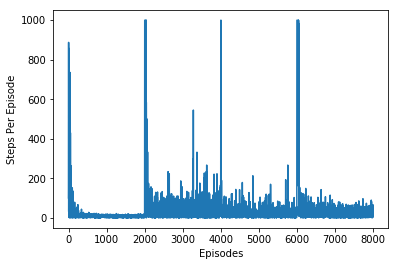

In [5]:
import matplotlib.pyplot as plt

plt.plot(xrange(nepisodes), np.mean(history[:, :, 0], axis=0))
plt.xlabel("Episodes")
plt.ylabel("Steps Per Episode")
if save:
    plt.savefig("plots/{}/learning_curve.png".format(experiment))
plt.show()

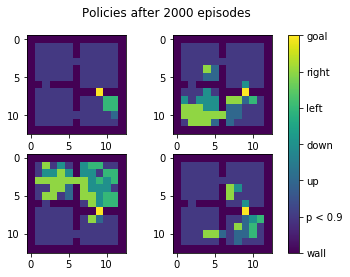

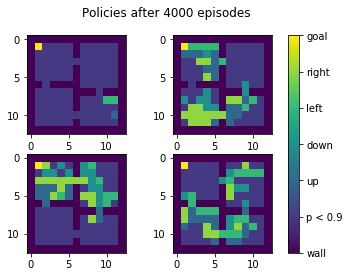

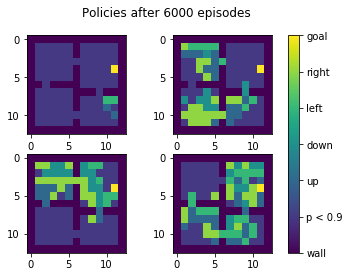

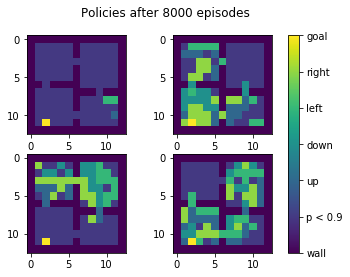

In [6]:
def visualize_policies(policies, goal, title, filename, threshold=0.9):
    fig, axs = plt.subplots(2, 2)
    
    for i in xrange(2):
        for j in xrange(2):
            policy = policies[2 * i + j]
            rooms_map = -2 * env.occupancy
            n_states = policy.weights.shape[0]
            n_actions = 4
            for s in xrange(n_states):
                max_prob = np.max(policy.pmf([s]))
                if max_prob > threshold:
                    rooms_map[env.tocell[s]] = np.argmax(policy.pmf([s]))
                else:
                    rooms_map[env.tocell[s]] = -1
            rooms_map[env.tocell[goal]] = 4
            im = axs[i, j].imshow(rooms_map)

    cbar = fig.colorbar(im, ax=axs.ravel().tolist())
    fig.suptitle(title)
    labels = ['wall', 'p < {}'.format(threshold), 'up', 'down', 'left', 'right', 'goal']
    cbar.ax.set_yticklabels(labels)
    if save:
        plt.savefig("plots/{}/{}.png".format(experiment, filename))
    plt.show()

for i in xrange(0, goal_idx + 1):
    policies = pickle.load(open("save/policies_{}.p".format(i), "rb"))
    visualize_policies(policies, goals[i], "Policies after {} episodes".format((i+1) * change_step),
                       "policies_{}".format(i))

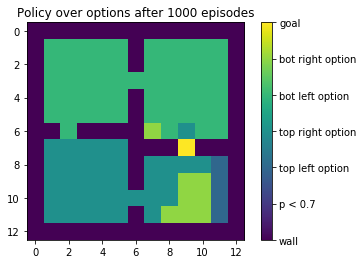

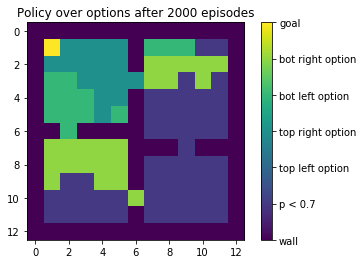

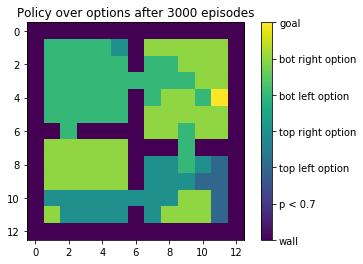

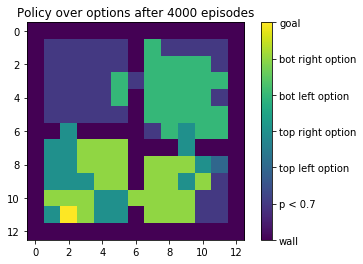

In [7]:
def visualize_policy(policy, goal, title, filename, threshold=0.7):
    rooms_map = -2 * env.occupancy
    n_states = policy.weights.shape[0]
    n_actions = 4
    for s in xrange(n_states):
        max_prob = np.max(policy.value([s]))
        if max_prob > threshold:
            rooms_map[env.tocell[s]] = np.argmax(policy.value([s]))
        else:
            rooms_map[env.tocell[s]] = -1
    rooms_map[env.tocell[goal]] = 4
    
    plt.imshow(rooms_map)
    plt.title(title)
    cbar = plt.colorbar()
    labels = ['wall', 'p < {}'.format(threshold), 'top left option', 
              'top right option', 'bot left option', 
              'bot right option', 'goal']
    cbar.ax.set_yticklabels(labels)
    if save:
        plt.savefig("plots/{}/{}.png".format(experiment, filename))
    plt.show()

for i in xrange(0, goal_idx + 1):
    policy_over_options = pickle.load(open("save/mainpolicy_{}.p".format(i), "rb"))
    visualize_policy(policy_over_options, goals[i], 
                     "Policy over options after {} episodes".format((i+1) * 1000), 
                     "main_policy_{}".format(i))

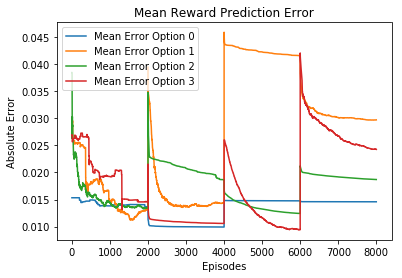

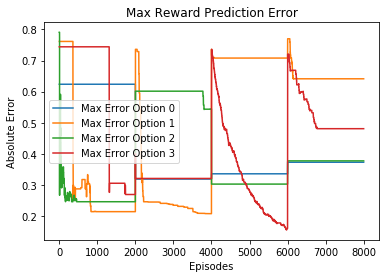

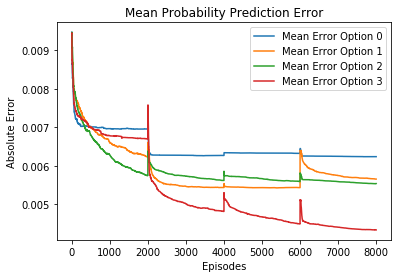

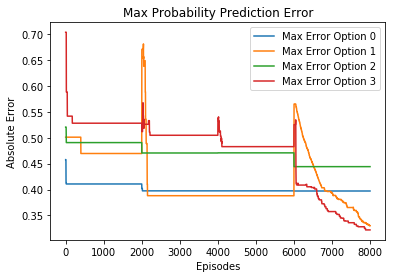

In [8]:
plt.plot(xrange(nepisodes), np.mean(mean_R_error[:, :, 0], axis=0), label="Mean Error Option 0")
plt.plot(xrange(nepisodes), np.mean(mean_R_error[:, :, 1], axis=0), label="Mean Error Option 1")
plt.plot(xrange(nepisodes), np.mean(mean_R_error[:, :, 2], axis=0), label="Mean Error Option 2")
plt.plot(xrange(nepisodes), np.mean(mean_R_error[:, :, 3], axis=0), label="Mean Error Option 3")
plt.title("Mean Reward Prediction Error")
plt.xlabel("Episodes")
plt.ylabel("Absolute Error")
plt.legend()
if save:
    plt.savefig("plots/{}/mean_reward_error.png".format(experiment))
plt.show()

plt.plot(xrange(nepisodes), np.mean(max_R_error[:, :, 0], axis=0), label="Max Error Option 0")
plt.plot(xrange(nepisodes), np.mean(max_R_error[:, :, 1], axis=0), label="Max Error Option 1")
plt.plot(xrange(nepisodes), np.mean(max_R_error[:, :, 2], axis=0), label="Max Error Option 2")
plt.plot(xrange(nepisodes), np.mean(max_R_error[:, :, 3], axis=0), label="Max Error Option 3")
plt.title("Max Reward Prediction Error")
plt.xlabel("Episodes")
plt.ylabel("Absolute Error")
plt.legend()
if save:
    plt.savefig("plots/{}/max_reward_error.png".format(experiment))
plt.show()

plt.plot(xrange(nepisodes), np.mean(mean_P_error[:, :, 0], axis=0), label="Mean Error Option 0")
plt.plot(xrange(nepisodes), np.mean(mean_P_error[:, :, 1], axis=0), label="Mean Error Option 1")
plt.plot(xrange(nepisodes), np.mean(mean_P_error[:, :, 2], axis=0), label="Mean Error Option 2")
plt.plot(xrange(nepisodes), np.mean(mean_P_error[:, :, 3], axis=0), label="Mean Error Option 3")
plt.title("Mean Probability Prediction Error")
plt.xlabel("Episodes")
plt.ylabel("Absolute Error")
plt.legend()
if save:
    plt.savefig("plots/{}/mean_proba_error.png".format(experiment))
plt.show()

plt.plot(xrange(nepisodes), np.mean(max_P_error[:, :, 0], axis=0), label="Max Error Option 0")
plt.plot(xrange(nepisodes), np.mean(max_P_error[:, :, 1], axis=0), label="Max Error Option 1")
plt.plot(xrange(nepisodes), np.mean(max_P_error[:, :, 2], axis=0), label="Max Error Option 2")
plt.plot(xrange(nepisodes), np.mean(max_P_error[:, :, 3], axis=0), label="Max Error Option 3")
plt.title("Max Probability Prediction Error")
plt.xlabel("Episodes")
plt.ylabel("Absolute Error")
plt.legend()
if save:
    plt.savefig("plots/{}/max_proba_error.png".format(experiment))
plt.show()

[ 0.62376207  0.76153005  0.79110592  0.74424402]


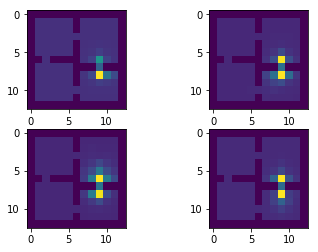

[ 0.31862461  0.73613712  0.60141745  0.32055974]


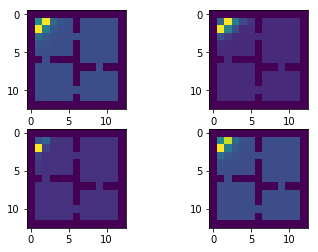

In [9]:
def visualize_rewards(R):
    fig, axs = plt.subplots(2, 2)
    for i in xrange(2):
        for j in xrange(2):
            rooms_map = -0.1 * env.occupancy
            for s in xrange(nfeatures):
                rooms_map[env.tocell[s]] = R[s, 2 * i + j]
            im = axs[i, j].imshow(rooms_map) 
    plt.show()

print np.max(R[0, 0], axis=0)
visualize_rewards(R[0, 0])
print np.max(R[0, 1], axis=0)
visualize_rewards(R[0, 1])